In [1]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools

import gsw

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy
import matplotlib.ticker as ticker
from matplotlib import animation, gridspec
from matplotlib.gridspec import GridSpec

ccrs = cartopy.crs

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

What do i want:

- mean temperature of decrease and std of events
- mean salinity of decrease and std of events
- mean density of decrease and std of events
- flip books 
    - hmxl
    - temp
    - salt
    - dens
    


In [2]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Before 1980

In [27]:
ds_temp = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_TEMP_2.0_40_20_aa_hist.nc')
ds_salt = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_SALT_2.0_40_20_aa_hist.nc')
ds_hmxl_aa = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_HMXL_2.0_40_20_aa_hist.nc')
ds_shf_aa  = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_SHF_2.0_40_20_aa_hist.nc')

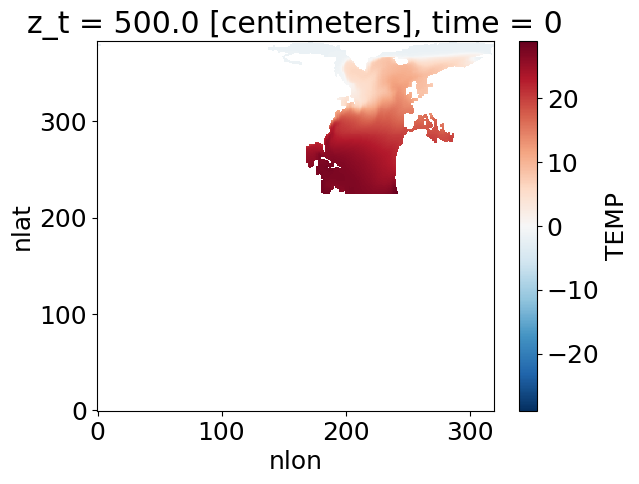

In [28]:
ds_temp.TEMP.isel(time=0, z_t=0).plot()

In [29]:
ds_hmxl_aa['HMXL']=ds_hmxl_aa.HMXL*1e-2

In [30]:
CT = gsw.conversions.CT_from_pt(ds_salt['SALT'], ds_temp['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp['TEMP'].dims, coords=ds_temp['TEMP'].coords)

ds_dens = ds_temp
ds_dens = ds_dens.drop_vars('TEMP')
ds_dens['DENS2'] = sigma2

## stream functions

In [5]:
ds_smoc = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_smoc_2.0_40_20_aa_hist.nc')
ds_dmoc = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_dmoc_2.0_40_20_aa_hist.nc')
ds_bsf = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_bsf_2.0_40_20_aa_hist.nc')

In [6]:
# get smoc in shape
numbers = np.array([29.70, 31.50, 33.15, 34.75, 35.80, 36.38, 36.70, 36.89, 37.06, 37.13, 37.30])
intervals = np.diff(numbers) / 4
result = np.concatenate([np.arange(numbers[i], numbers[i+1], intervals[i]) for i in range(len(intervals))])
density_bins = np.append(result, numbers[-1])

ds_smoc = ds_smoc.rename({'__xarray_dataarray_variable__': 'sMOC'})

ds_keep = ds_dens.isel(nlon=0).squeeze()
ds_smoc = ds_smoc.assign_coords(TLAT=ds_keep.TLAT)
replacement_value = 0
ds_smoc['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_smoc['TLAT']), np.isinf(ds_smoc['TLAT']) | np.ma.getmask(ds_smoc['TLAT'])),
    replacement_value,
    ds_smoc['TLAT']
)

# get dmoc in shape
ds_dmoc = ds_dmoc.rename({'__xarray_dataarray_variable__': 'dMOC'})
ds_dmoc = ds_dmoc.assign_coords(TLAT=ds_smoc.TLAT)

# get bsf in shape
ds_bsf = ds_bsf.rename({'__xarray_dataarray_variable__': 'BSF'})
ds_bsf = ds_bsf.assign_coords(TLAT=ds_bsf.TLAT)

#### plot simple functions

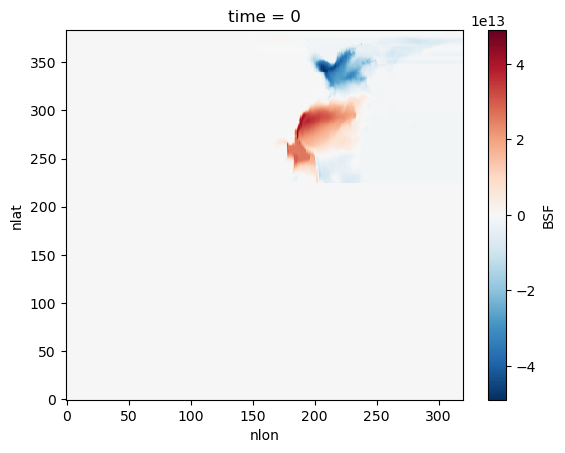

In [145]:
ds_bsf.BSF.isel(time=0).plot()

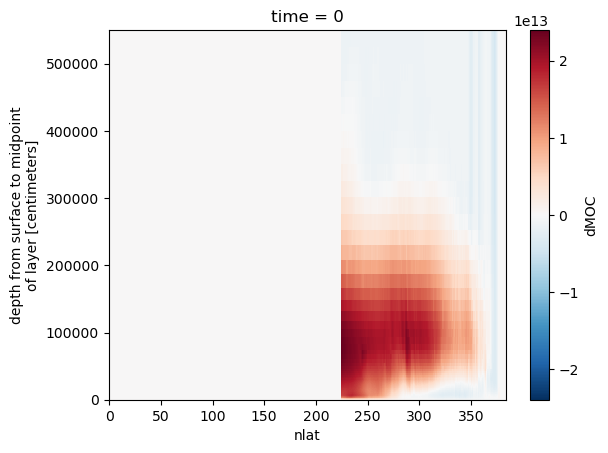

In [146]:
ds_dmoc.dMOC.isel(time=0).plot()

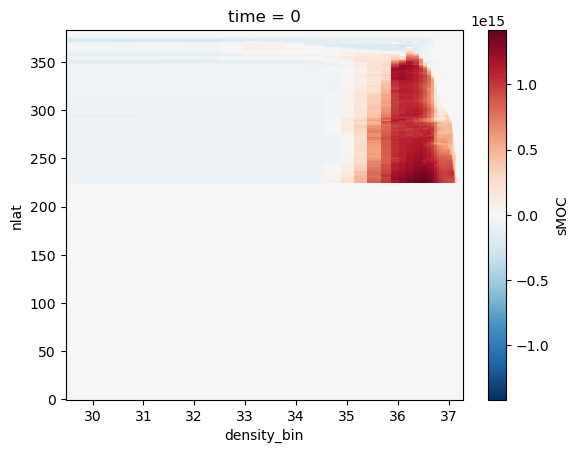

In [147]:
ds_smoc.sMOC.isel(time=0).plot()

### anomalies

#### streamfunctions

In [7]:
smoc_anomaly = ds_smoc.sMOC.isel(time=slice(41,59)).mean('time')-ds_smoc.sMOC.isel(time=slice(0,40)).mean('time')
dmoc_anomaly = ds_dmoc.dMOC.isel(time=slice(41,59)).mean('time')-ds_dmoc.dMOC.isel(time=slice(0,40)).mean('time')
bsf_anomaly = ds_bsf.BSF.isel(time=slice(41,59)).mean('time')-ds_bsf.BSF.isel(time=slice(0,40)).mean('time')

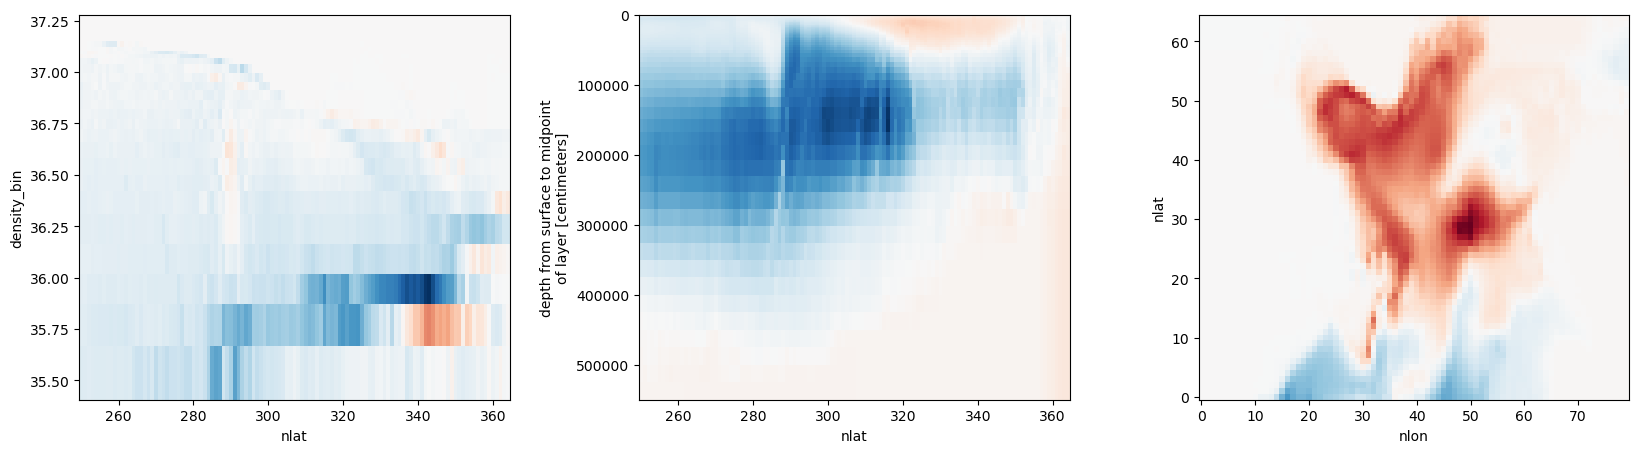

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

fig.subplots_adjust(wspace=0.3)

# Plot the differences in respective subplots
smoc_anomaly.isel(nlat=slice(250, 365), density_bin=slice(15, 40)).transpose().plot(ax=axs[0], add_colorbar=False)

dmoc_anomaly.isel(nlat=slice(250, 365)).plot(ax=axs[1], add_colorbar=False)
axs[1].invert_yaxis()

bsf_anomaly.isel(nlat=slice(300, 365), nlon=slice(180,260)).plot(ax=axs[2], add_colorbar=False)

#### hydrographic variables

In [9]:
temp_anomaly = ds_temp.TEMP.isel(time=slice(41,59)).mean('time')-ds_temp.TEMP.isel(time=slice(0,40)).mean('time')
salt_anomaly = ds_salt.SALT.isel(time=slice(41,59)).mean('time')-ds_salt.SALT.isel(time=slice(0,40)).mean('time')
dens_anomaly = ds_dens.DENS2.isel(time=slice(41,59)).mean('time')-ds_dens.DENS2.isel(time=slice(0,40)).mean('time')

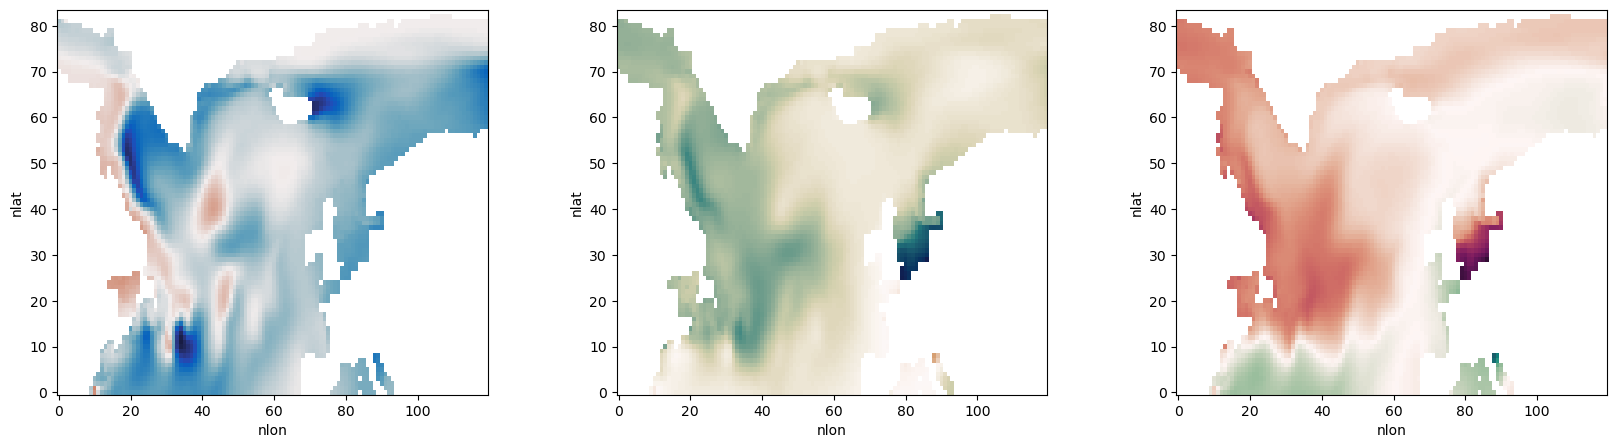

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

fig.subplots_adjust(wspace=0.3)

temp_anomaly.isel(nlat=slice(300, 400), nlon=slice(180,300)).sel(z_t=slice(0, 10000)).mean('z_t').plot(ax=axs[0], add_colorbar=False, cmap = cmo.balance)

salt_anomaly.isel(nlat=slice(300, 400), nlon=slice(180,300)).sel(z_t=slice(0, 10000)).mean('z_t').plot(ax=axs[1], add_colorbar=False, cmap = cmo.tarn_r)

dens_anomaly.isel(nlat=slice(300, 400), nlon=slice(180,300)).sel(z_t=slice(0, 10000)).mean('z_t').plot(ax=axs[2], add_colorbar=False, cmap = cmo.curl_r)

## flip books

#### smoc

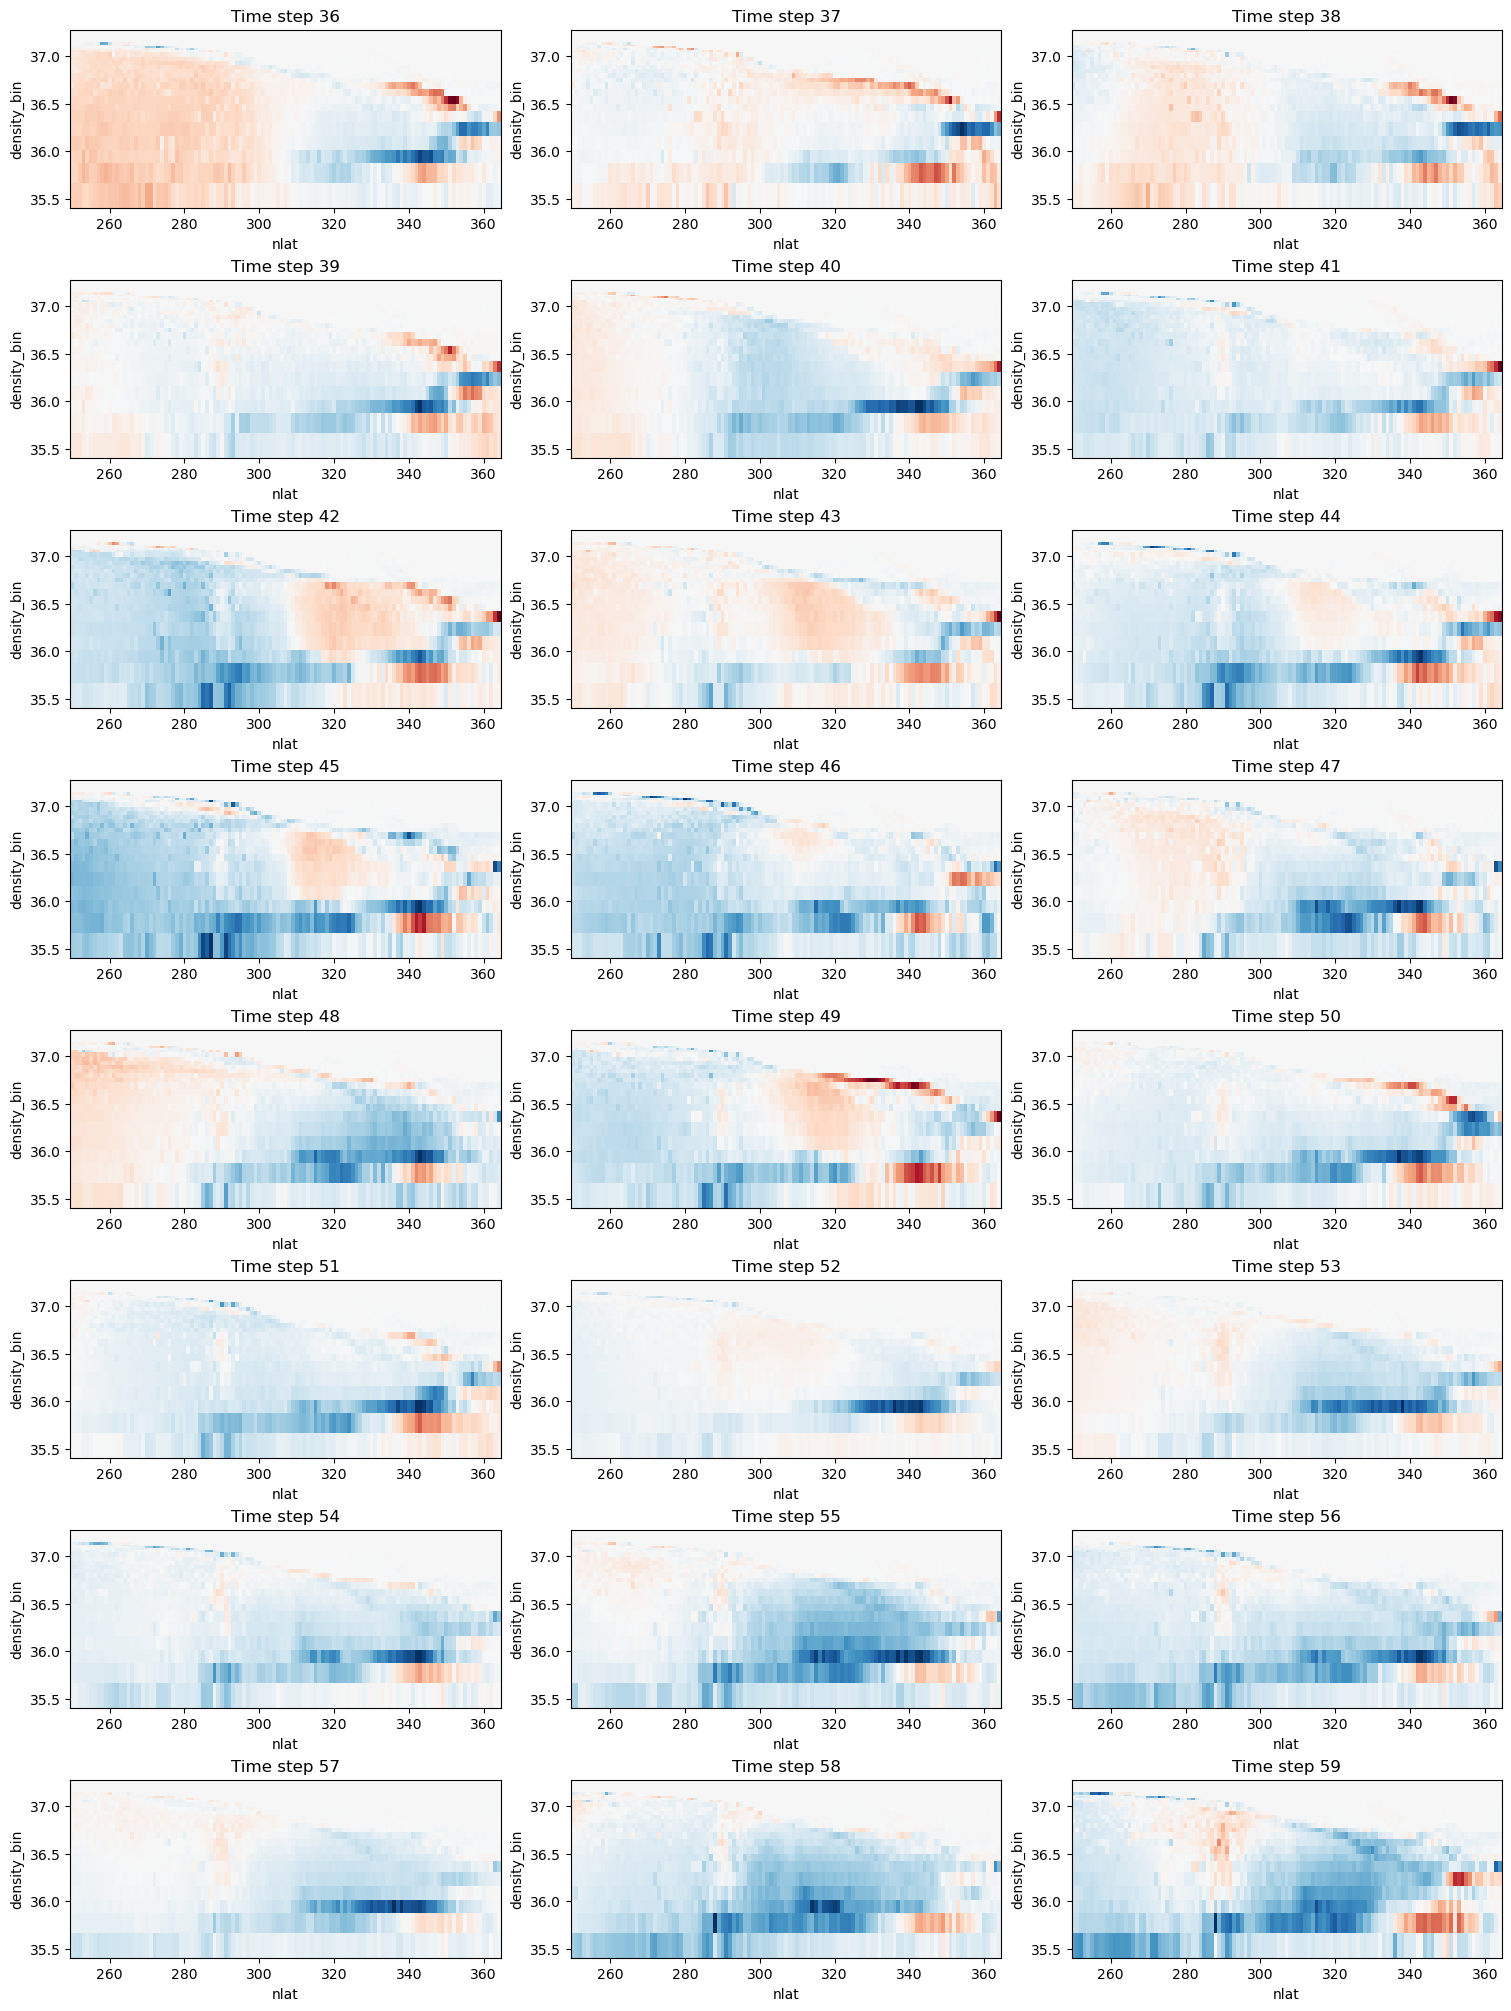

In [155]:
fig, axs = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Loop through the specified time steps and create subplots
for i, time_step in enumerate(range(36, 60)):
    
    ds = ds_smoc.sMOC - ds_smoc.sMOC.isel(time=slice(0, 40)).mean('time')
    data = ds.isel(time=time_step, nlat=slice(250, 365), density_bin=slice(15, 40)).transpose()
    data.plot(ax=axs[i], add_colorbar=False)
    axs[i].set_title(f'Time step {time_step}')

# Show the plot
plt.show()

#### dmoc

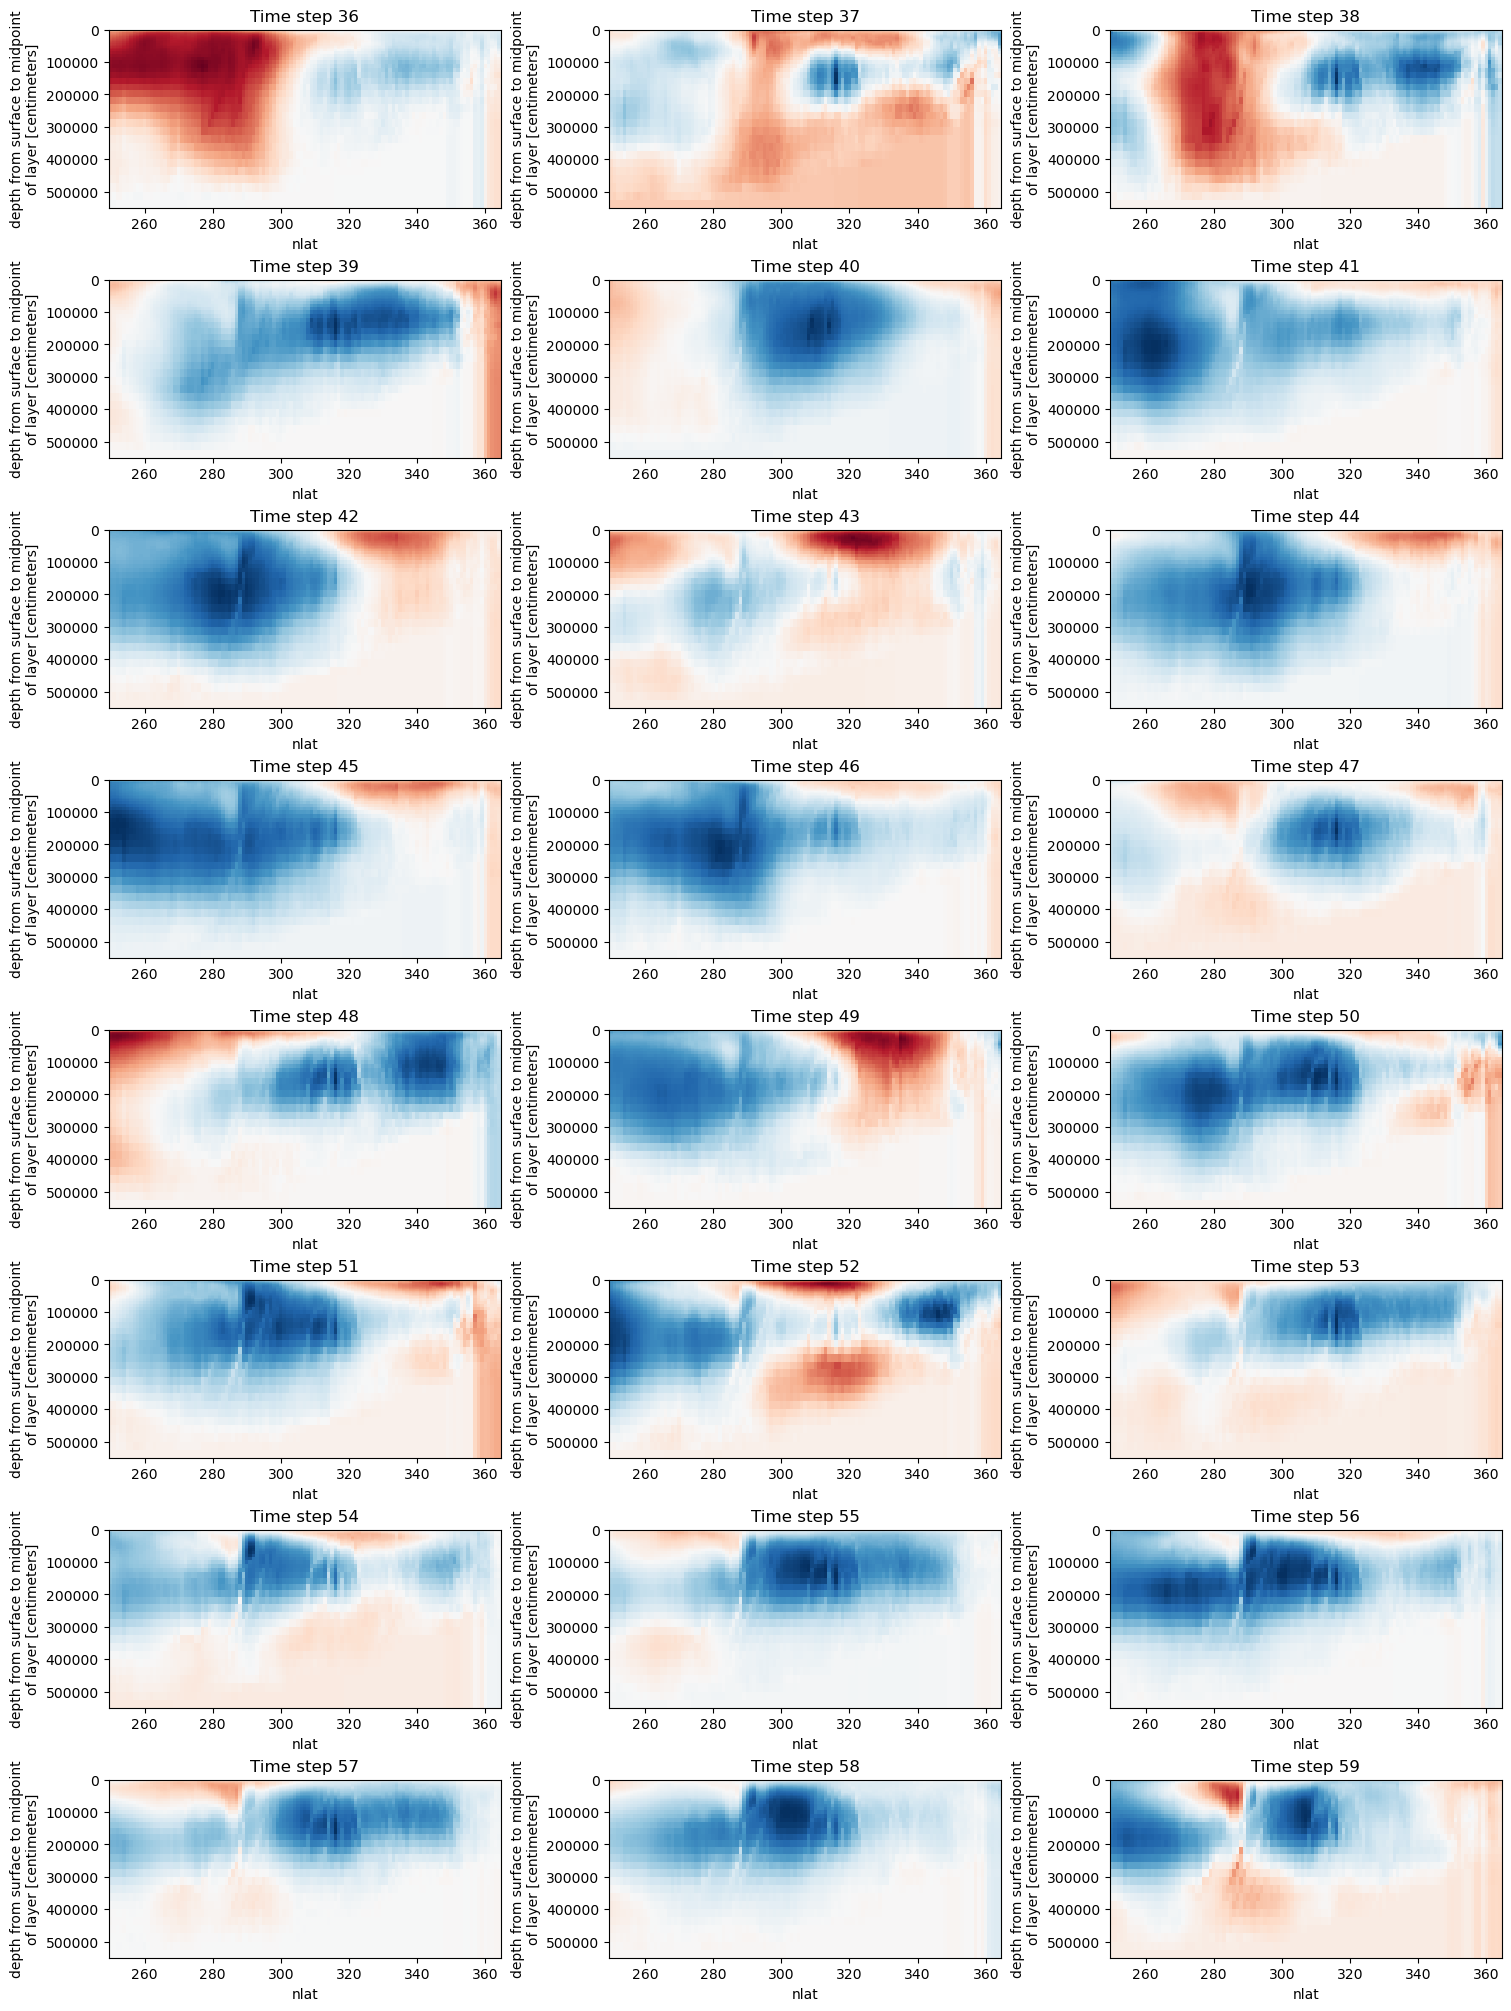

In [17]:
fig, axs = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Loop through the specified time steps and create subplots
for i, time_step in enumerate(range(36, 60)):
    
    ds = ds_dmoc.dMOC - ds_dmoc.dMOC.isel(time=slice(0, 40)).mean('time')
    data = ds.isel(time=time_step, nlat=slice(250, 365))
    data.plot(ax=axs[i], add_colorbar=False)
    axs[i].invert_yaxis()
    axs[i].set_title(f'Time step {time_step}')

# Show the plot
plt.show()

#### bsf

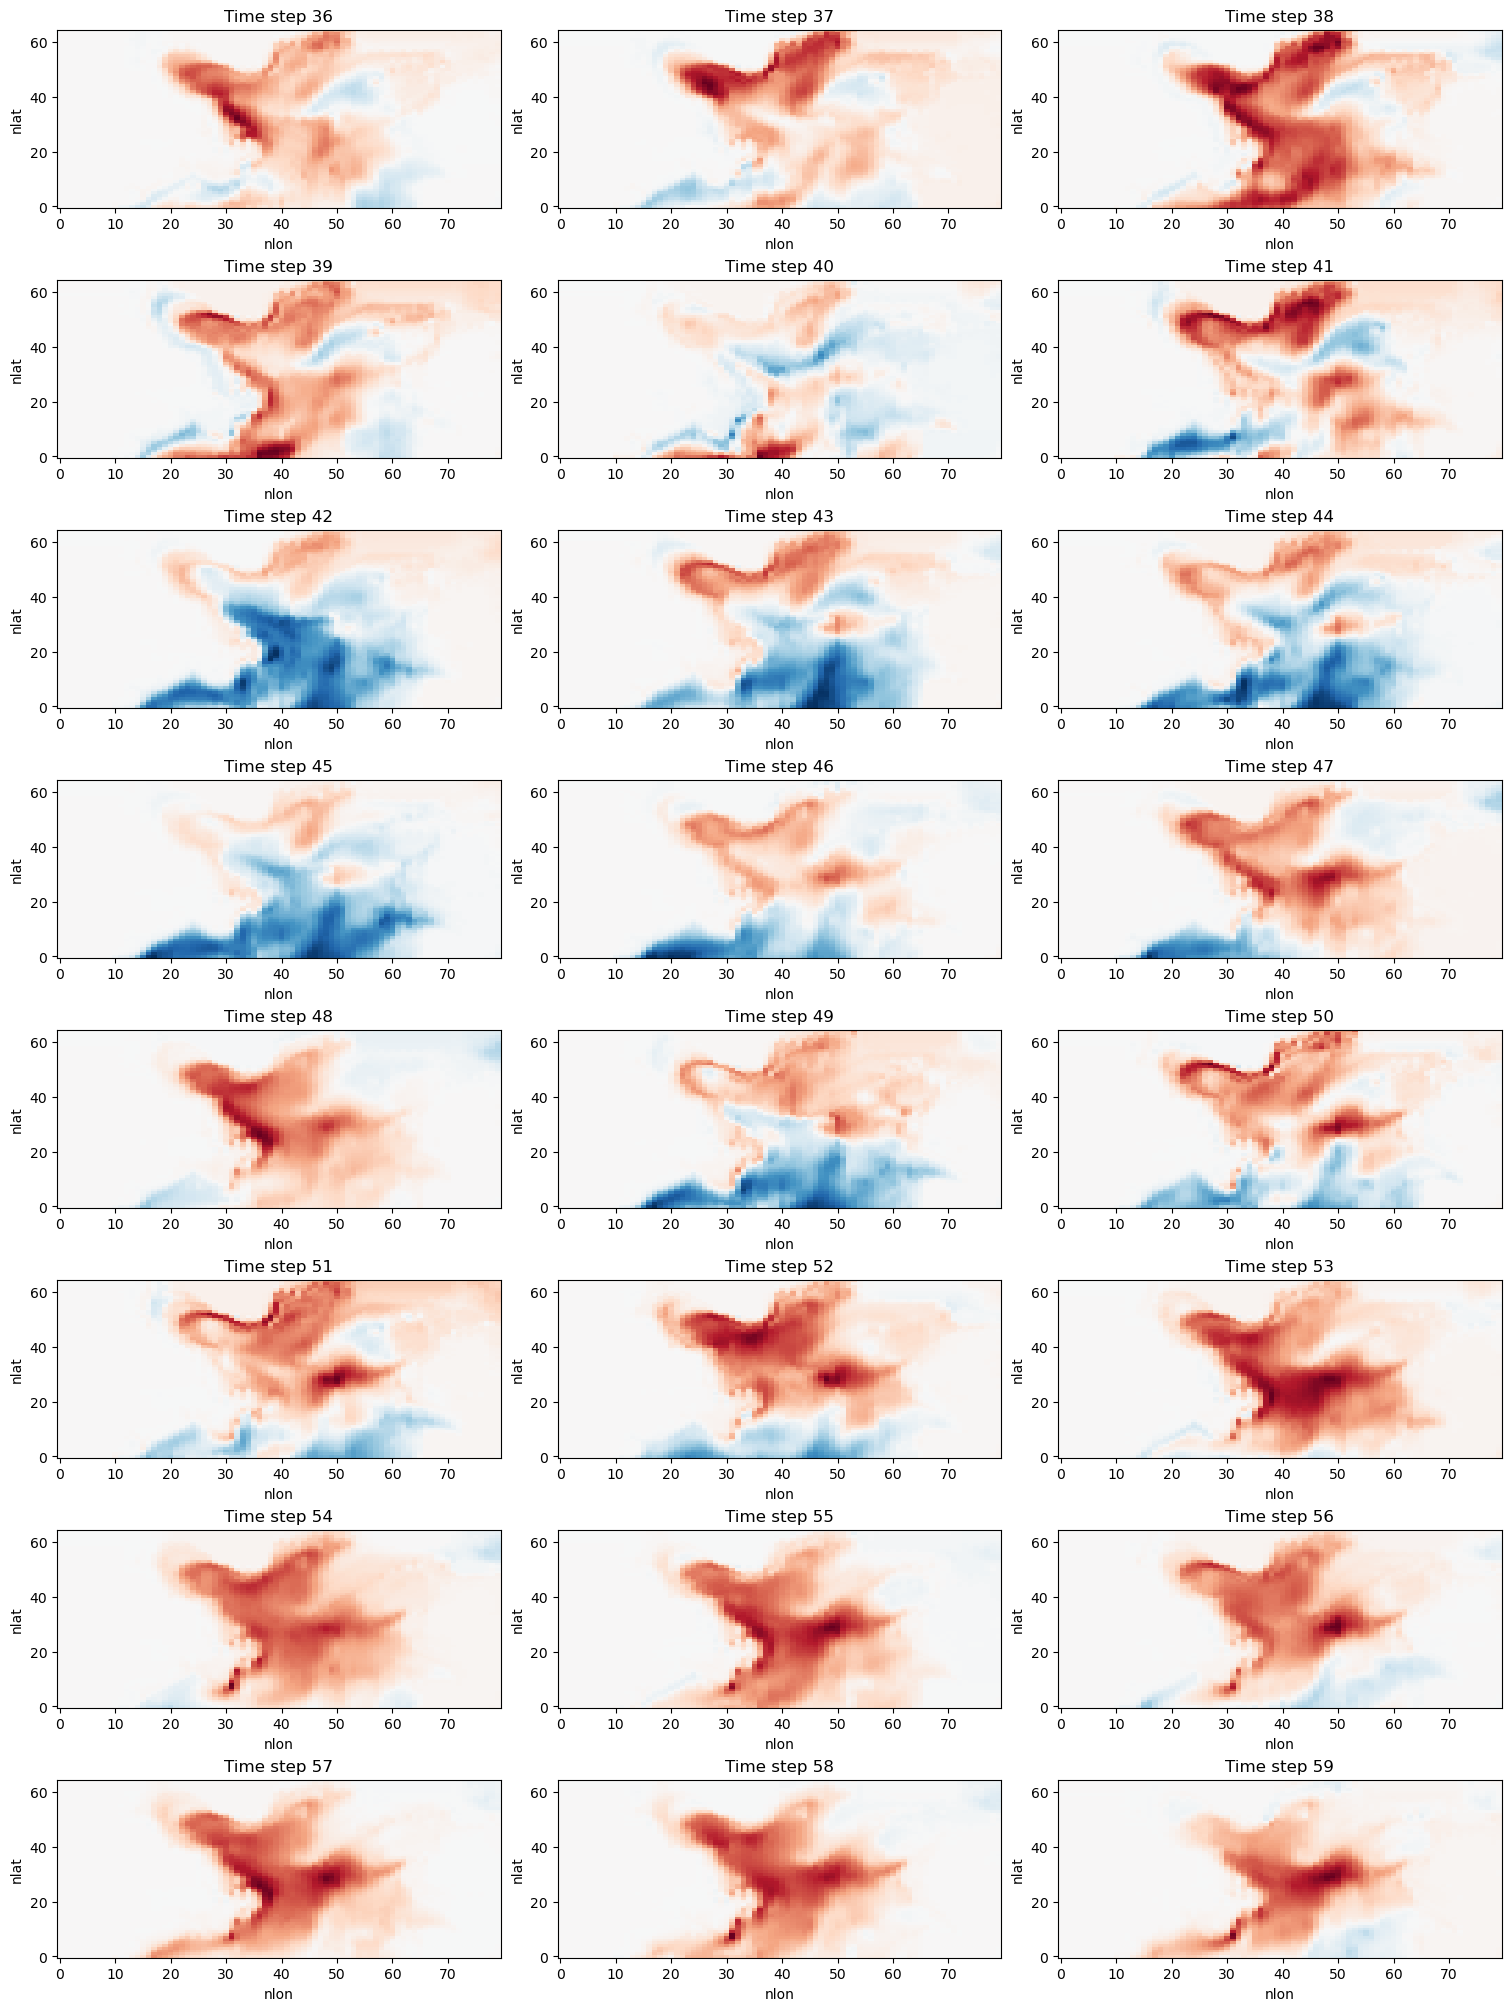

In [157]:
fig, axs = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Loop through the specified time steps and create subplots
for i, time_step in enumerate(range(36, 60)):
    
    ds = ds_bsf.BSF - ds_bsf.BSF.isel(time=slice(0, 40)).mean('time')
    data = ds.isel(time=time_step, nlat=slice(300, 365), nlon=slice(180,260))
    data.plot(ax=axs[i], add_colorbar=False)
    axs[i].set_title(f'Time step {time_step}')

# Show the plot
plt.show()

### hydrographic variables

In [31]:
datasets = {
    'TEMP': ds_temp.roll(nlon=+100),
    'SALT': ds_salt.roll(nlon=+100),
    'DENS2': ds_dens.roll(nlon=+100),
    'HMXL': ds_hmxl_aa.roll(nlon=+100),
    'SHF': ds_shf_aa.roll(nlon=+100)
}

# Define the replacement value
replacement_value = 0

# Iterate over the list of datasets and replace NaN, inf, and masked values
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT']
    )
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG']
    )

In [32]:
variables = ['TEMP', 'SALT', 'DENS2']#, 'HMXL', 'SHF']
labels = [r'Temperature Anomaly over first 100 metres (Period 1 - Specific Decade)  $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly first over first 100 metres (Period 1 - Specific Decade)  $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly over first 100 metres (Period 1 - Specific Decade) $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]',
          r'Mixed Layer Depth Anomaly (Period 1 - Period 2) $\Delta h$ [$m$]',
          r'Surface Heat Flux Anomaly (Period 1 - Period 2) $\Delta\Phi$ [$\frac{W}{m^2}$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r, 'seismic', cmo.delta]
vmins = [-1, -0.4, -0.3, -200, -75]

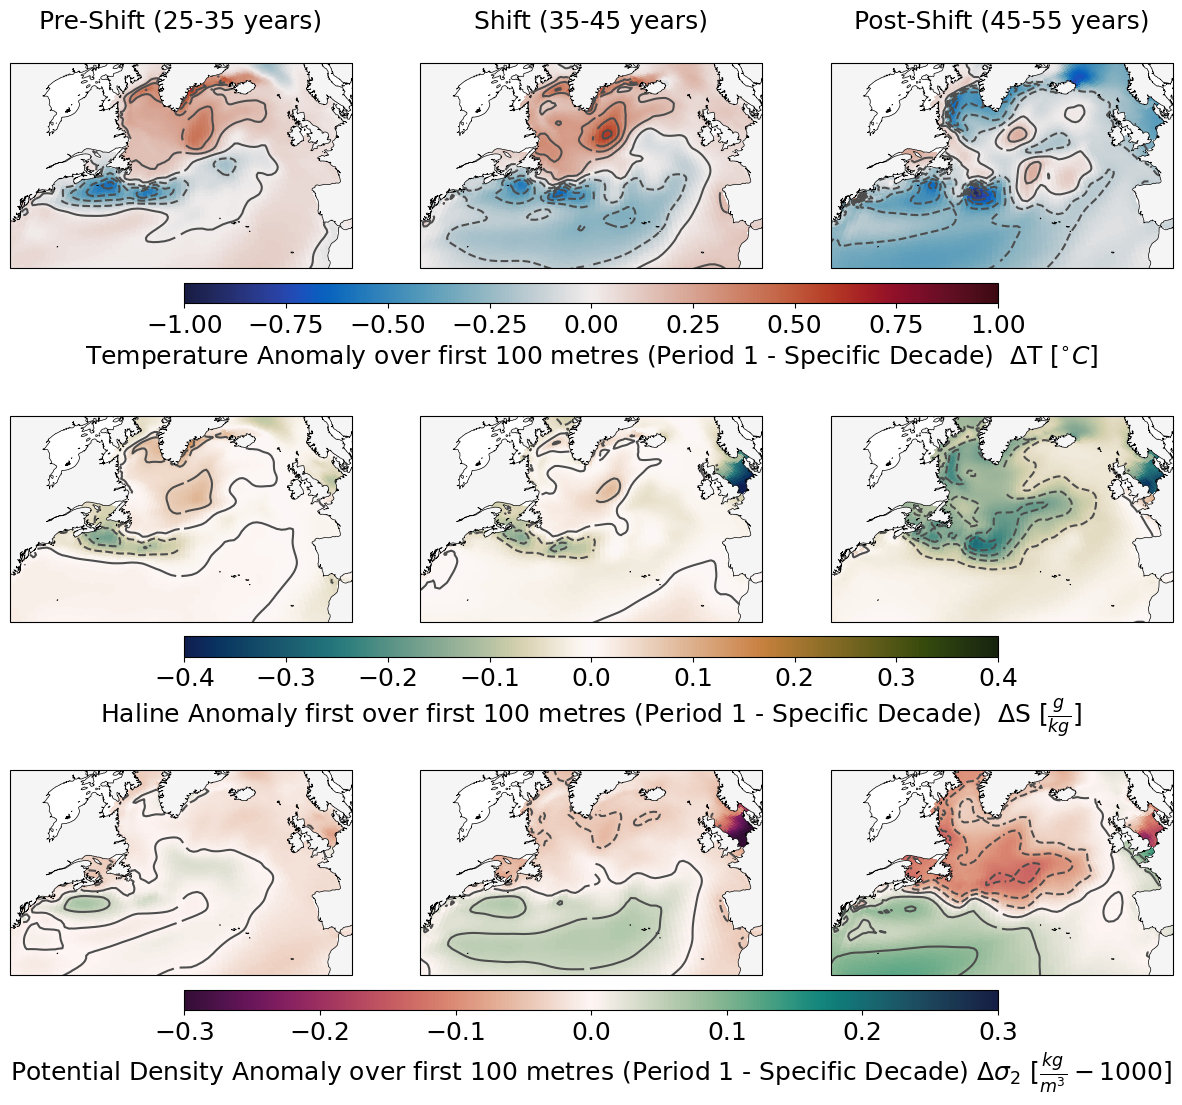

In [33]:
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20),  # Adjusted height for 5 rows
#                         subplot_kw={'projection': ccrs.Orthographic(central_latitude=20, central_longitude=-35)})
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13),  # Adjusted height for 5 rows
                         subplot_kw={'projection': ccrs.Orthographic(central_latitude=20, central_longitude=-35)})



plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Shift (25-35 years)', 'Shift (35-45 years)', 'Post-Shift (45-55 years)']

for row, var in enumerate(variables):
    if var in ['HMX', 'SHF']:
        ds_var_annual = datasets[var]
    else:
        ds_var_annual = datasets[var].sel(z_t=slice(500, 10500)).mean('z_t')
    
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0, 40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds.isel(time=slice(start, end)).mean('time')[var].plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-75, -5, 30, 69], crs=ccrs.PlateCarree())
        ax.add_feature(nature_coast)
        #cs = ax.contour(
        #    ds.TLONG, ds.TLAT, ds_var_annual.isel(time=slice(0, 40)).mean('time')[var].where(mask == 1), 
        #    linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        #)
        
        cs = ax.contour(
            ds.TLONG.where(mask==1), ds.TLAT.where(mask==1), ds.isel(time=slice(start, end)).mean('time')[var], 
            levels = np.linspace(vmin, vmax, 15),
            linewidths=1.5, colors='#4d4d4d', transform=ccrs.PlateCarree()
        )
        
        #ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
#fig.suptitle(r'2$\sigma$ Decreased Circulation Shifts -- aa hist', fontsize=20, fontweight='bold', x=0.5, y=0.95)  # bottom-left (0, 0) and top-right (1, 1)

#plt.show()
plt.savefig('Figure_aa_decrease_flipbooks.png', bbox_inches='tight', dpi=300, transparent=True)      

## time series

In [6]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [200.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [260.0, 360.0]}}]}
SPNA_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
SPNA_mask = SPNA_mask.sum('region')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [20]:
depth_slice = slice(None, 50000)

ds_masked_temp = ds_temp.where(SPNA_mask == 1).sel(z_t=depth_slice)
ds_masked_salt = ds_salt.where(SPNA_mask == 1).sel(z_t=depth_slice)

weights = ds_masked_temp.z_t.sel(z_t=depth_slice) * ds_masked_temp.TAREA
weights = weights.fillna(0)

#temp_weighted_mean = (ds_temp.TEMP.where(SPNA_mask == 1).sel(z_t=depth_slice) * weights).sum(dim=['nlat', 'nlon', 'z_t']) / weights.sum(dim=['nlat', 'nlon', 'z_t'])
#salt_weighted_mean = (ds_salt.SALT.where(SPNA_mask == 1).sel(z_t=depth_slice) * weights).sum(dim=['nlat', 'nlon', 'z_t']) / weights.sum(dim=['nlat', 'nlon', 'z_t'])

temp_weighted_mean = ds_masked_temp.TEMP.weighted(weights).mean(dim=['nlat', 'nlon', 'z_t'])
salt_weighted_mean = ds_masked_salt.SALT.weighted(weights).mean(dim=['nlat', 'nlon', 'z_t'])


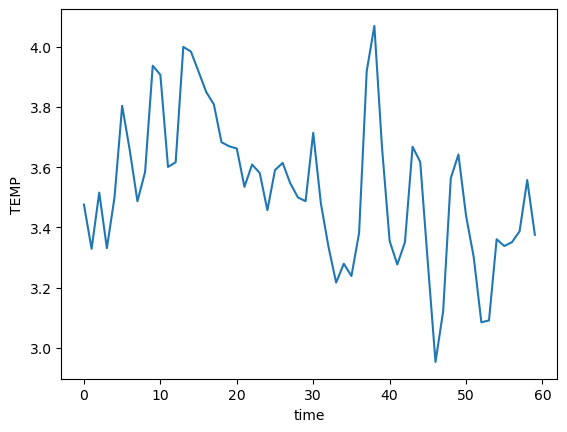

In [21]:
temp_weighted_mean.plot()
#salt_weighted_mean.plot()

### Plot heat and freshwater content

In [188]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [200.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [260.0, 360.0]}}
    ]
}

# Create mask for selected regions
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')

ds_temp = ds_temp.where(mask == 1)
ds_salt = ds_salt.where(mask == 1)

In [189]:
# Define physical constants
rho_sw = 1026  # density of seawater in kg/m^3
cp_sw = 3990  # specific heat of seawater in J/(kg·K)

# Convert units to meters and square meters
ds_salt['dz'] = ds_temp.dz * 1e-2
ds_temp['UAREA'] = ds_temp.UAREA * 1e-4

# Define reference salinity
S_ref = 35  # PSU

# Convert units to meters and square meters
ds_salt['dz'] = ds_salt.dz * 1e-2
ds_salt['UAREA'] = ds_salt.UAREA * 1e-4

In [190]:
# Compute heat content
heat_content = rho_sw * cp_sw * (ds_temp.dz * ds_temp.UAREA * ds_temp.TEMP).sum(dim=['nlat', 'nlon', 'z_t'])

# Freshwater content computation (add this line)
freshwater_content = ((S_ref - ds_salt.SALT) / S_ref * ds_salt.dz * ds_salt.UAREA).sum(dim=['nlat', 'nlon', 'z_t'])

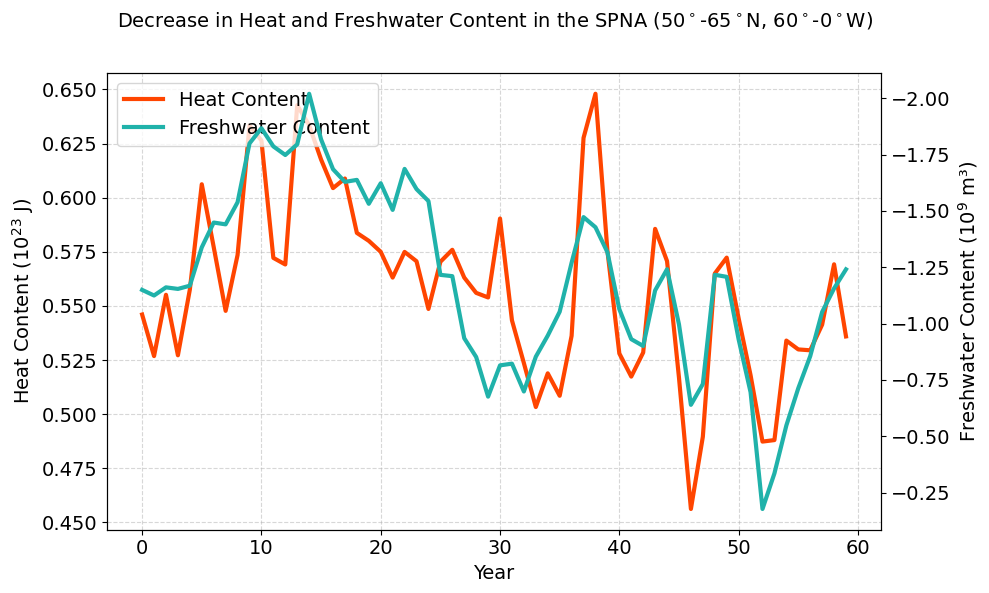

In [191]:
# Define a consistent font size
fontsize = 14

# Define the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot heat content time series
ax1.plot(heat_content.time, heat_content / 1e23, color='orangered', label='Heat Content', linewidth = 3)
ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel('Heat Content ($10^{23}$ J)', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Twin axis for freshwater content and flip y-axis
ax2 = ax1.twinx()
ax2.invert_yaxis()
ax2.plot(freshwater_content.time, freshwater_content / 1e9, color='lightseagreen', label='Freshwater Content', linewidth = 3)
ax2.set_ylabel('Freshwater Content ($10^9$ m³)', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=fontsize)

# Title
fig.suptitle(r'Decrease in Heat and Freshwater Content in the SPNA (50$^\circ$-65$^\circ$N, 60$^\circ$-0$^\circ$W)', fontsize=fontsize)

# Grid and Layout
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('Figure_aa_decrease_content.png', bbox_inches='tight', dpi=300)

# Show the plot
#plt.show()

# After 1980

In [34]:
ds_temp = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_TEMP_3.0_40_20.nc')
ds_salt = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_SALT_3.0_40_20.nc')
ds_hmxl_ghg = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_HMXL_3.0_40_20.nc')
ds_shf_ghg  = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_SHF_3.0_40_20.nc')

In [35]:
ds_hmxl_ghg['HMXL']=ds_hmxl_ghg.HMXL*1e-2

In [36]:
CT = gsw.conversions.CT_from_pt(ds_salt['SALT'], ds_temp['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp['TEMP'].dims, coords=ds_temp['TEMP'].coords)

ds_dens = ds_temp
ds_dens = ds_dens.drop_vars('TEMP')
ds_dens['DENS2'] = sigma2

## stream functions

In [21]:
ds_smoc = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_smoc_3.0_40_20_ghg_hist.nc')
ds_dmoc = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_dmoc_3.0_40_20_ghg_hist.nc')
ds_bsf = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_bsf_3.0_40_20_ghg_hist.nc')

In [22]:
# get smoc in shape
numbers = np.array([29.70, 31.50, 33.15, 34.75, 35.80, 36.38, 36.70, 36.89, 37.06, 37.13, 37.30])
intervals = np.diff(numbers) / 4
result = np.concatenate([np.arange(numbers[i], numbers[i+1], intervals[i]) for i in range(len(intervals))])
density_bins = np.append(result, numbers[-1])

ds_smoc = ds_smoc.rename({'__xarray_dataarray_variable__': 'sMOC'})

ds_keep = ds_dens.isel(nlon=0).squeeze()
ds_smoc = ds_smoc.assign_coords(TLAT=ds_keep.TLAT)
replacement_value = 0
ds_smoc['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_smoc['TLAT']), np.isinf(ds_smoc['TLAT']) | np.ma.getmask(ds_smoc['TLAT'])),
    replacement_value,
    ds_smoc['TLAT']
)

# get dmoc in shape
ds_dmoc = ds_dmoc.rename({'__xarray_dataarray_variable__': 'dMOC'})
ds_dmoc = ds_dmoc.assign_coords(TLAT=ds_smoc.TLAT)

# get bsf in shape
ds_bsf = ds_bsf.rename({'__xarray_dataarray_variable__': 'BSF'})
ds_bsf = ds_bsf.assign_coords(TLAT=ds_bsf.TLAT)

### anomalies

In [23]:
smoc_anomaly = ds_smoc.sMOC.isel(time=slice(41,59)).mean('time')-ds_smoc.sMOC.isel(time=slice(0,40)).mean('time')
dmoc_anomaly = ds_dmoc.dMOC.isel(time=slice(41,59)).mean('time')-ds_dmoc.dMOC.isel(time=slice(0,40)).mean('time')
bsf_anomaly = ds_bsf.BSF.isel(time=slice(41,59)).mean('time')-ds_bsf.BSF.isel(time=slice(0,40)).mean('time')

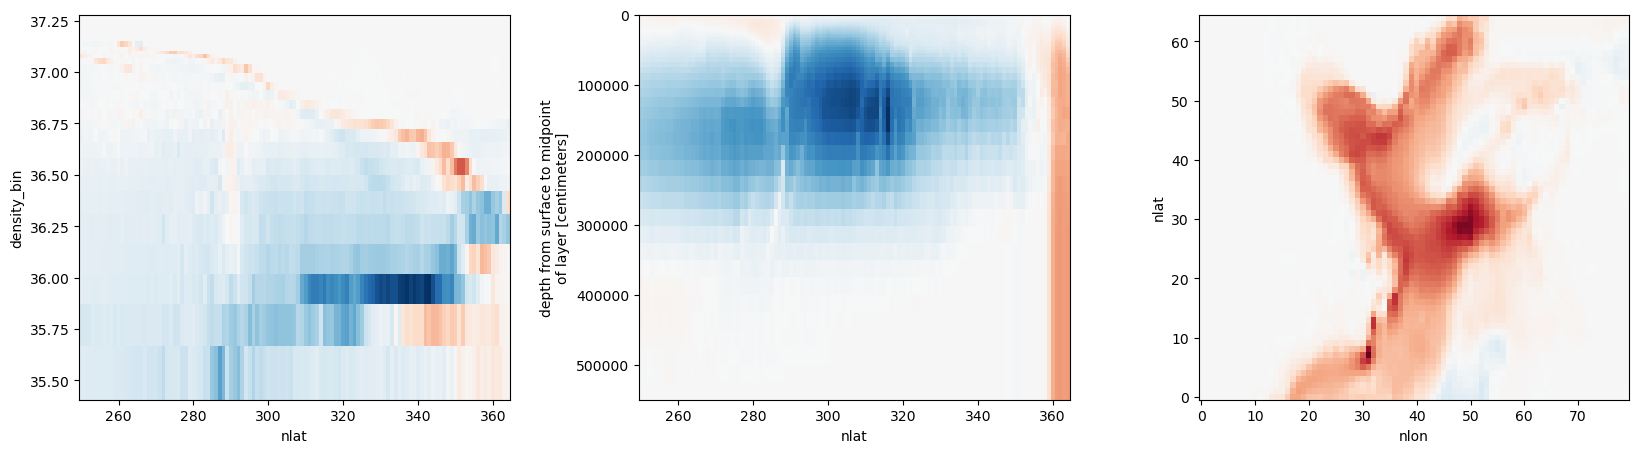

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

fig.subplots_adjust(wspace=0.3)

# Plot the differences in respective subplots
smoc_anomaly.isel(nlat=slice(250, 365), density_bin=slice(15, 40)).transpose().plot(ax=axs[0], add_colorbar=False)

dmoc_anomaly.isel(nlat=slice(250, 365)).plot(ax=axs[1], add_colorbar=False)
axs[1].invert_yaxis()

bsf_anomaly.isel(nlat=slice(300, 365), nlon=slice(180,260)).plot(ax=axs[2], add_colorbar=False)

#### hydrographic variables

In [12]:
temp_anomaly = ds_temp.TEMP.isel(time=slice(41,59)).mean('time')-ds_temp.TEMP.isel(time=slice(0,40)).mean('time')
salt_anomaly = ds_salt.SALT.isel(time=slice(41,59)).mean('time')-ds_salt.SALT.isel(time=slice(0,40)).mean('time')
dens_anomaly = ds_dens.DENS2.isel(time=slice(41,59)).mean('time')-ds_dens.DENS2.isel(time=slice(0,40)).mean('time')

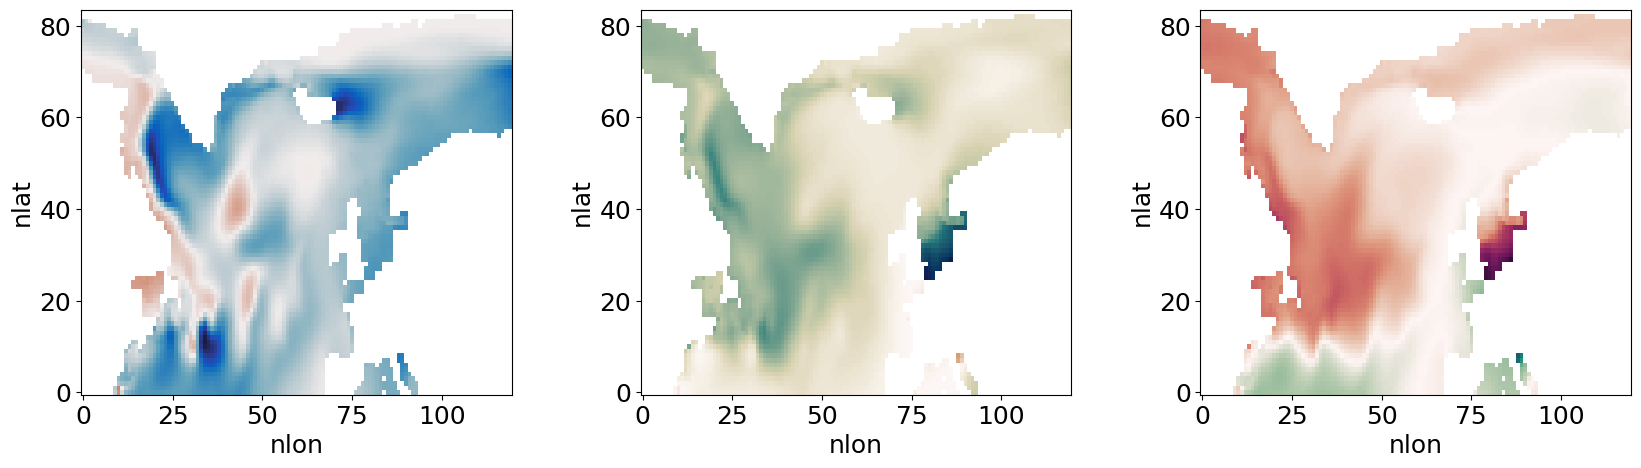

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

fig.subplots_adjust(wspace=0.3)

temp_anomaly.isel(nlat=slice(300, 400), nlon=slice(180,300)).sel(z_t=slice(0, 10000)).mean('z_t').plot(ax=axs[0], add_colorbar=False, cmap = cmo.balance)

salt_anomaly.isel(nlat=slice(300, 400), nlon=slice(180,300)).sel(z_t=slice(0, 10000)).mean('z_t').plot(ax=axs[1], add_colorbar=False, cmap = cmo.tarn_r)

dens_anomaly.isel(nlat=slice(300, 400), nlon=slice(180,300)).sel(z_t=slice(0, 10000)).mean('z_t').plot(ax=axs[2], add_colorbar=False, cmap = cmo.curl_r)

## flip books

### smoc flip books

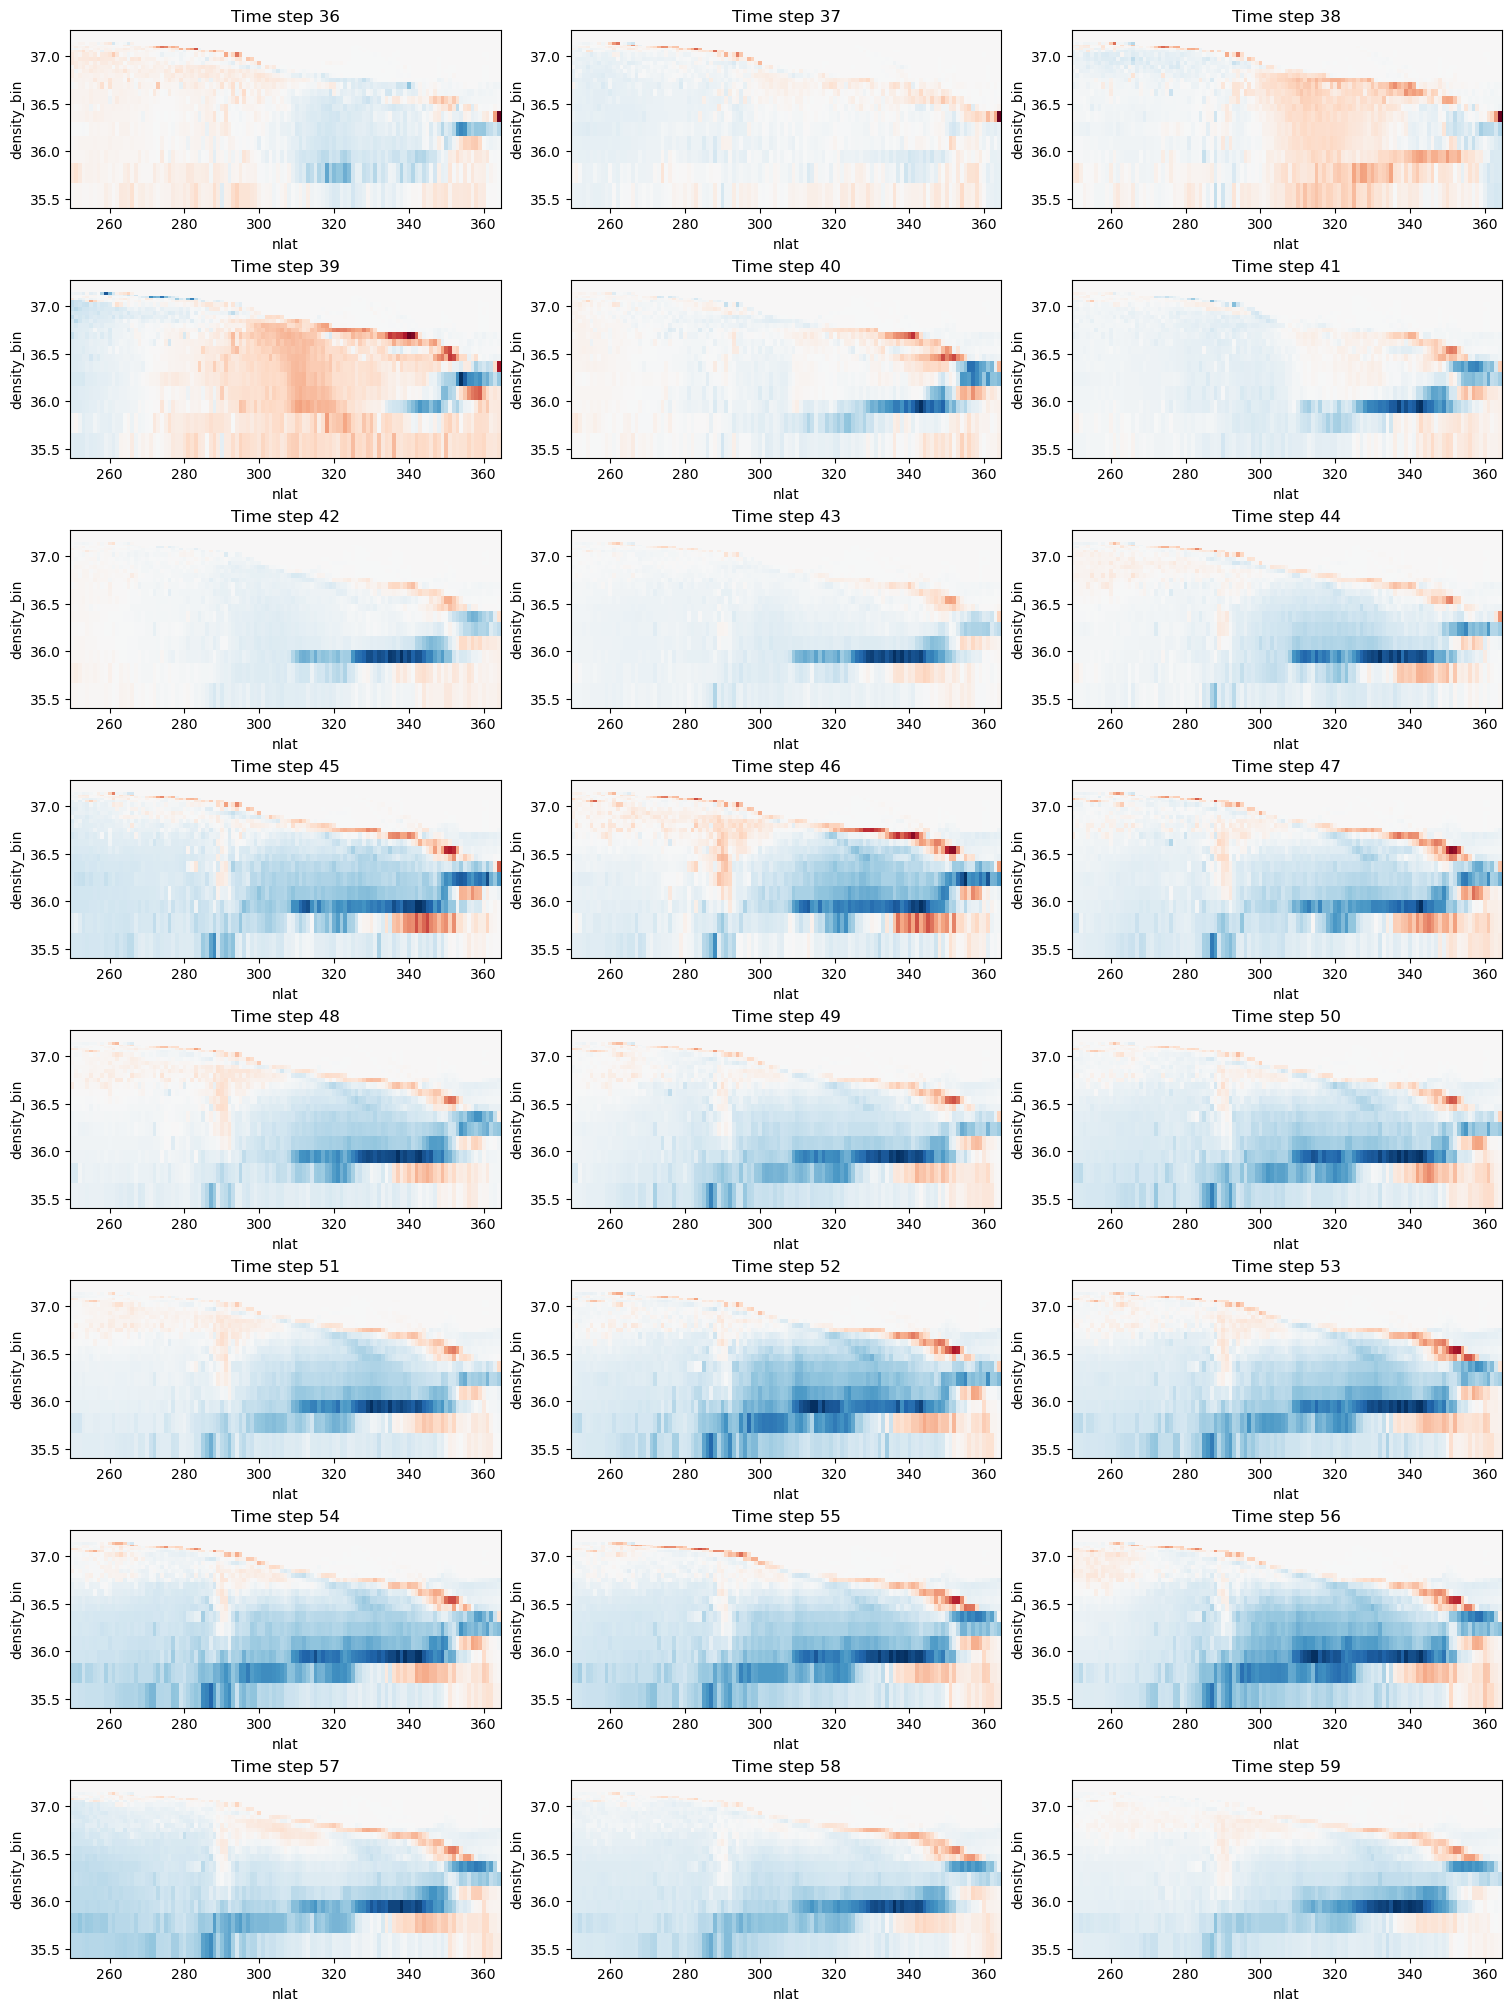

In [13]:
fig, axs = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Loop through the specified time steps and create subplots
for i, time_step in enumerate(range(36, 60)):
    
    ds = ds_smoc.sMOC - ds_smoc.sMOC.isel(time=slice(0, 40)).mean('time')
    data = ds.isel(time=time_step, nlat=slice(250, 365), density_bin=slice(15, 40)).transpose()
    data.plot(ax=axs[i], add_colorbar=False)
    axs[i].set_title(f'Time step {time_step}')

# Show the plot
plt.show()

### dmoc flip books

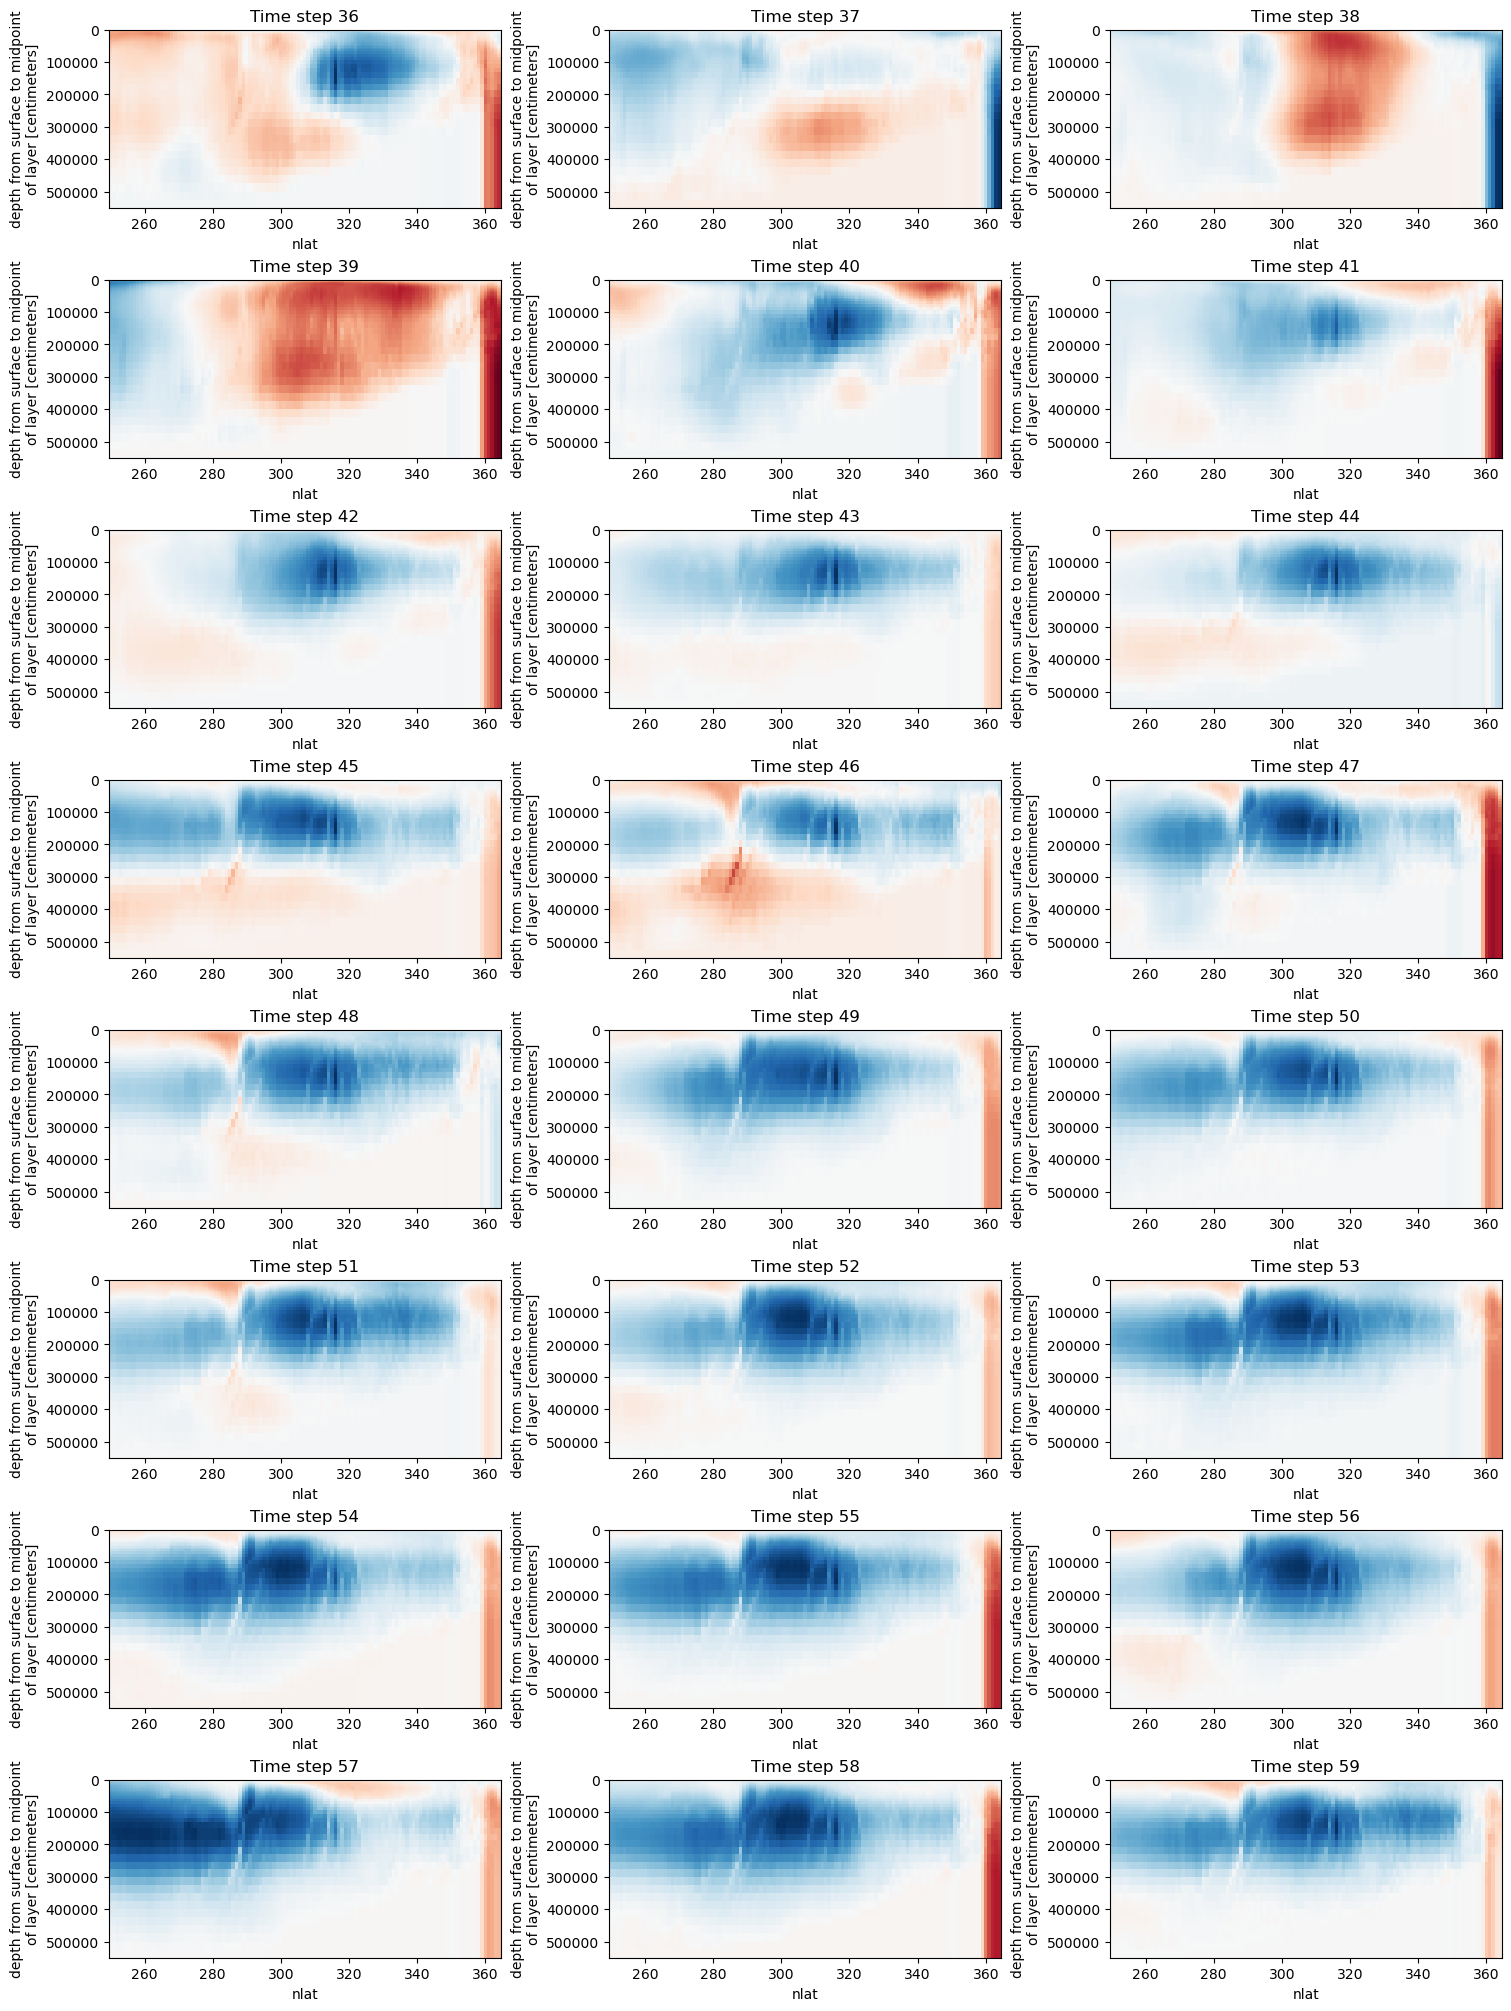

In [25]:
fig, axs = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Loop through the specified time steps and create subplots
for i, time_step in enumerate(range(36, 60)):
    
    ds = ds_dmoc.dMOC - ds_dmoc.dMOC.isel(time=slice(0, 40)).mean('time')
    data = ds.isel(time=time_step, nlat=slice(250, 365))
    data.plot(ax=axs[i], add_colorbar=False)
    axs[i].set_title(f'Time step {time_step}')
    axs[i].invert_yaxis()

# Show the plot
plt.show()

### bsf flip books

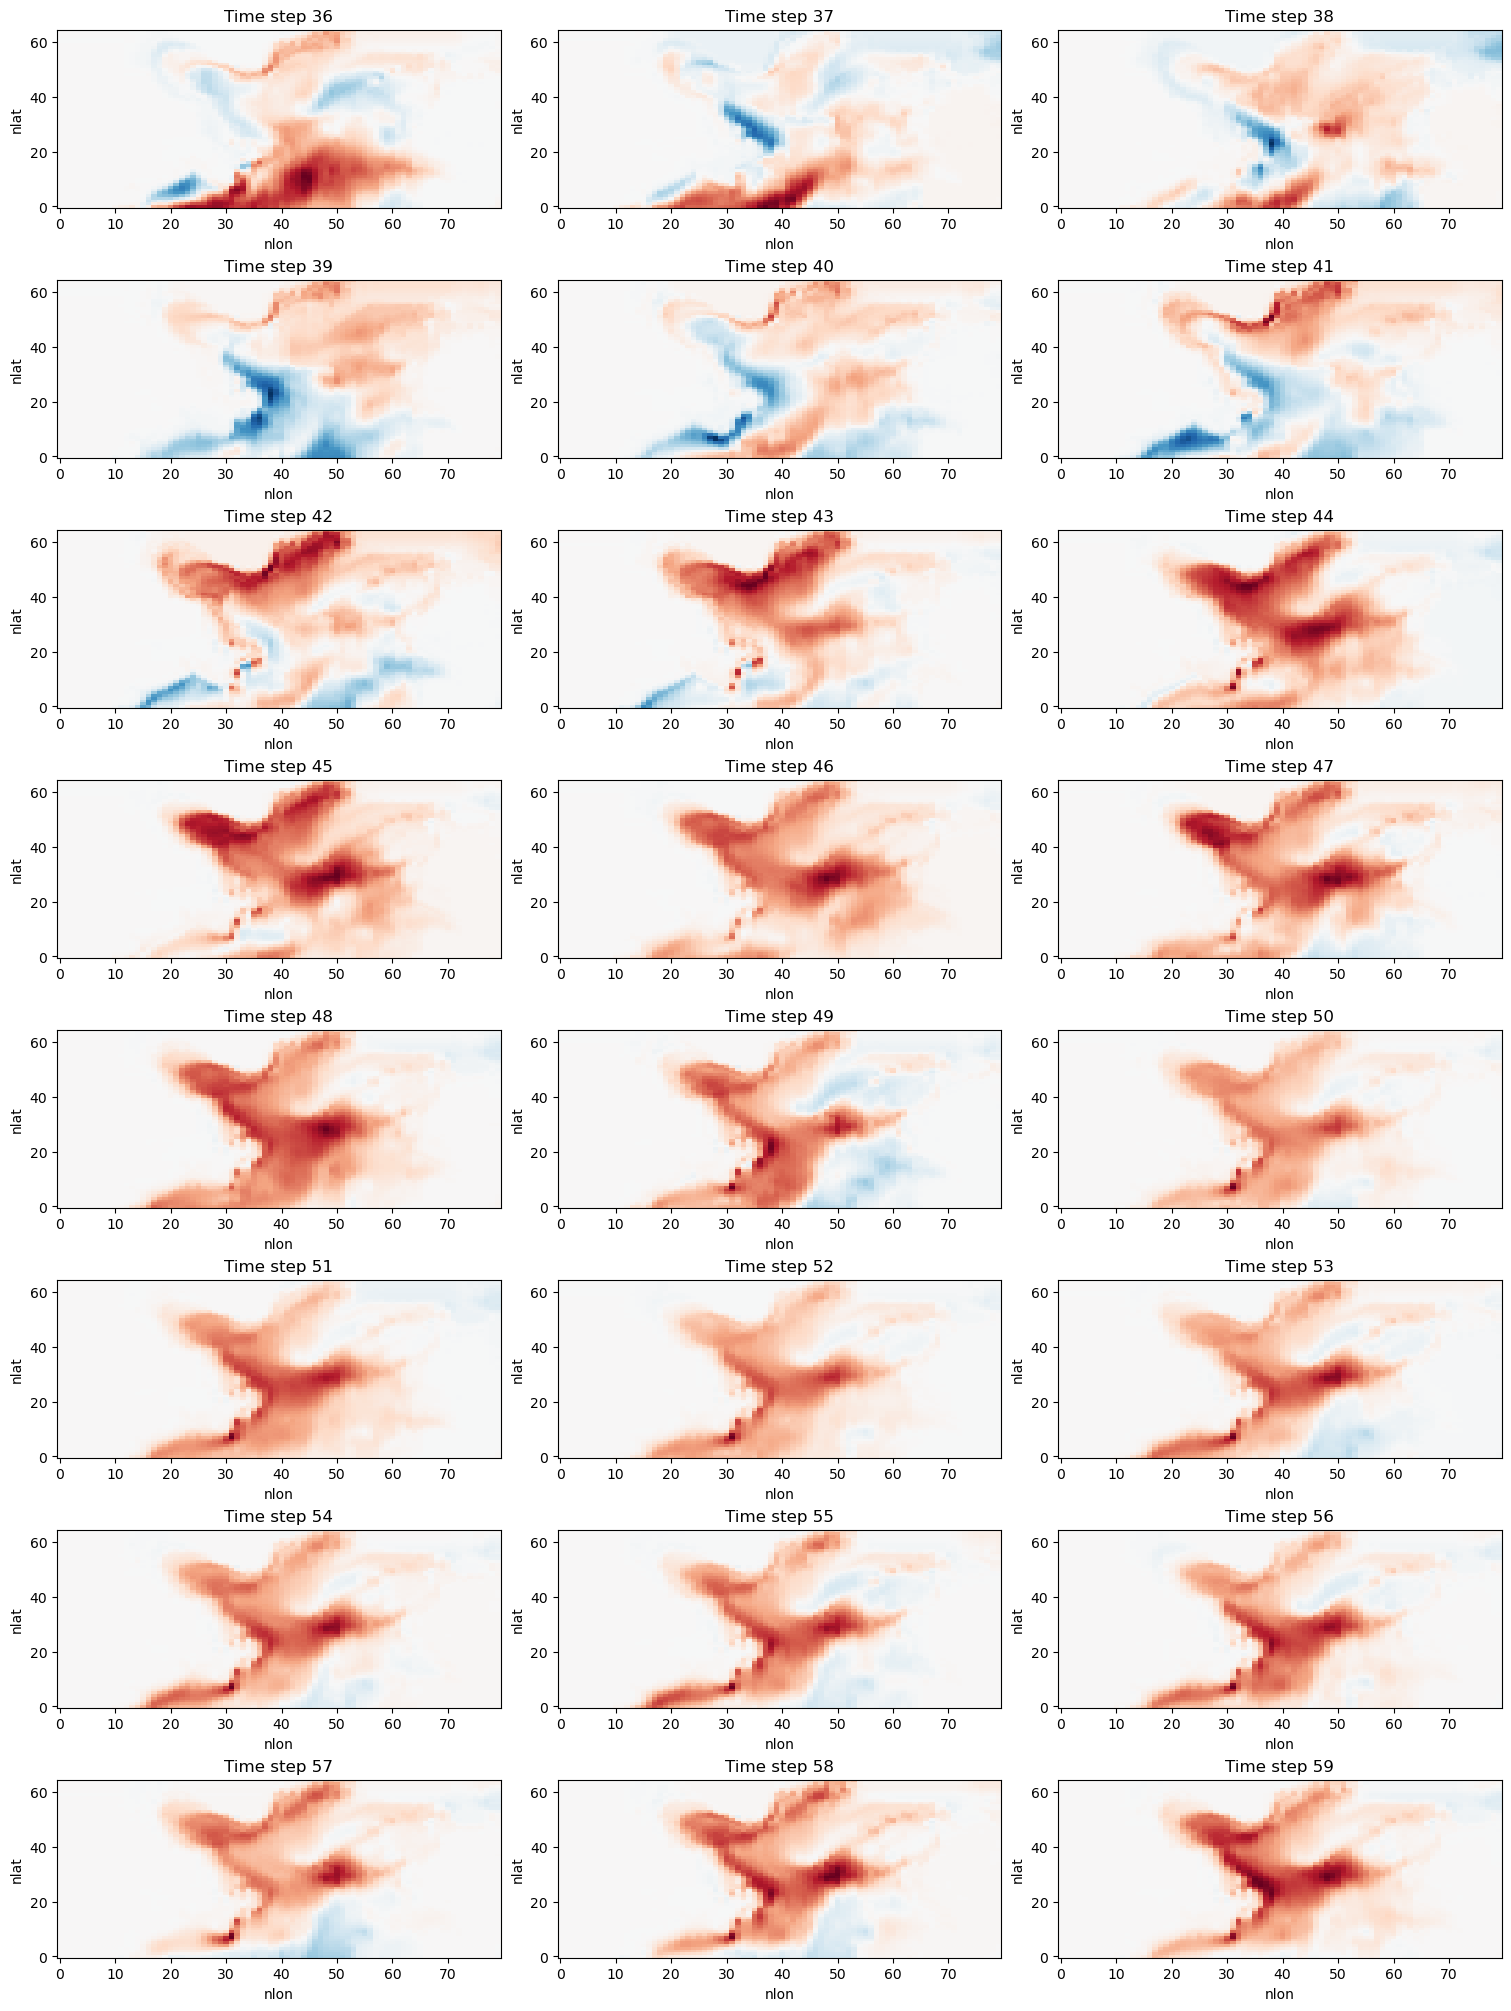

In [15]:
fig, axs = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Loop through the specified time steps and create subplots
for i, time_step in enumerate(range(36, 60)):
    
    ds = ds_bsf.BSF - ds_bsf.BSF.isel(time=slice(0, 40)).mean('time')
    data = ds.isel(time=time_step, nlat=slice(300, 365), nlon=slice(180,260))
    data.plot(ax=axs[i], add_colorbar=False)
    axs[i].set_title(f'Time step {time_step}')

# Show the plot
plt.show()

### hydropgraphic flip books

In [37]:
datasets = {
    'TEMP': ds_temp.roll(nlon=+100),
    'SALT': ds_salt.roll(nlon=+100),
    'DENS2': ds_dens.roll(nlon=+100),
    'HMXL': ds_hmxl_ghg.roll(nlon=+100),
    'SHF': ds_shf_ghg.roll(nlon=+100)
}

# Define the replacement value
replacement_value = 0

# Iterate over the list of datasets and replace NaN, inf, and masked values
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT']
    )
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG']
    )

In [38]:
variables = ['TEMP', 'SALT', 'DENS2']#, 'HMXL', 'SHF']
labels = [r'Temperature Anomaly over first 100 metres (Period 1 - Specific Decade)  $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly first over first 100 metres (Period 1 - Specific Decade)  $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly over first 100 metres (Period 1 - Specific Decade) $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]',
          r'Mixed Layer Depth Anomaly (Period 1 - Period 2) $\Delta h$ [$m$]',
          r'Surface Heat Flux Anomaly (Period 1 - Period 2) $\Delta\Phi$ [$\frac{W}{m^2}$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r, 'seismic', cmo.delta]
vmins = [-1, -0.4, -0.3, -200, -75]

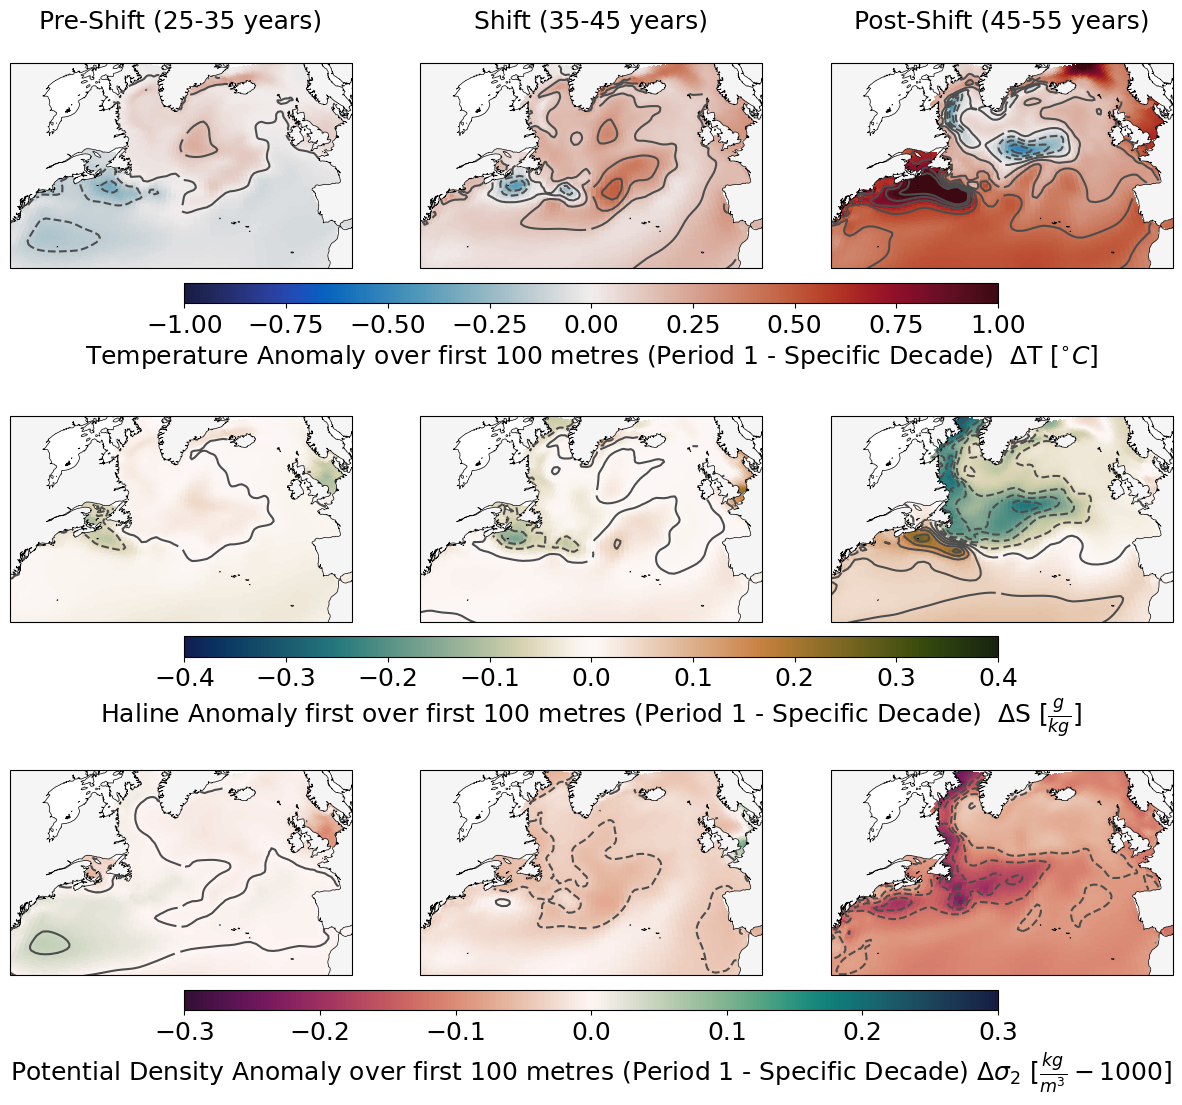

In [39]:
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20),  # Adjusted height for 5 rows
#                         subplot_kw={'projection': ccrs.Orthographic(central_latitude=20, central_longitude=-35)})
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13),  # Adjusted height for 5 rows
                         subplot_kw={'projection': ccrs.Orthographic(central_latitude=20, central_longitude=-35)})


plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Shift (25-35 years)', 'Shift (35-45 years)', 'Post-Shift (45-55 years)']


for row, var in enumerate(variables):
    if var in ['HMX', 'SHF']:
        ds_var_annual = datasets[var]
    else:
        ds_var_annual = datasets[var].sel(z_t=slice(500, 10500)).mean('z_t')
    
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0, 40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds.isel(time=slice(start, end)).mean('time')[var].plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-75, -5, 30, 69], crs=ccrs.PlateCarree())
        ax.add_feature(nature_coast)
        #cs = ax.contour(
        #    ds.TLONG, ds.TLAT, ds_var_annual.isel(time=slice(0, 40)).mean('time')[var].where(mask == 1), 
        #    linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        #)
        
        cs = ax.contour(
            ds.TLONG.where(mask==1), ds.TLAT.where(mask==1), ds.isel(time=slice(start, end)).mean('time')[var], 
            levels = np.linspace(vmin, vmax, 15),
            linewidths=1.5, colors='#4d4d4d', transform=ccrs.PlateCarree()
        )
        
        #ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
#fig.suptitle(r'3$\sigma$ Decreased Circulation Shifts -- ghg hist', fontsize=20, fontweight='bold', x=0.5, y=0.95)  # bottom-left (0, 0) and top-right (1, 1)

#plt.show()
plt.savefig('Figure_decrease_flipbooks.png', bbox_inches='tight', dpi=300)      

## time series

### heat and freshwater content

In [2]:
ds_temp = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_TEMP_3.0_40_20.nc').roll(nlon=+100)
ds_salt = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_SALT_3.0_40_20.nc').roll(nlon=+100)

In [3]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [200.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [260.0, 360.0]}}
    ]
}

# Create mask for selected regions
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')

ds_temp = ds_temp.where(mask == 1)
ds_salt = ds_salt.where(mask == 1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# Define physical constants
rho_sw = 1026  # density of seawater in kg/m^3
cp_sw = 3990  # specific heat of seawater in J/(kg·K)

# Convert units to meters and square meters
ds_salt['dz'] = ds_temp.dz * 1e-2
ds_temp['UAREA'] = ds_temp.UAREA * 1e-4

# Define reference salinity
S_ref = 35  # PSU

# Convert units to meters and square meters
ds_salt['dz'] = ds_salt.dz * 1e-2
ds_salt['UAREA'] = ds_salt.UAREA * 1e-4

In [5]:
# Compute heat content
heat_content = rho_sw * cp_sw * (ds_temp.dz * ds_temp.UAREA * ds_temp.TEMP).sum(dim=['nlat', 'nlon', 'z_t'])

# Freshwater content computation (add this line)
freshwater_content = ((S_ref - ds_salt.SALT) / S_ref * ds_salt.dz * ds_salt.UAREA).sum(dim=['nlat', 'nlon', 'z_t'])

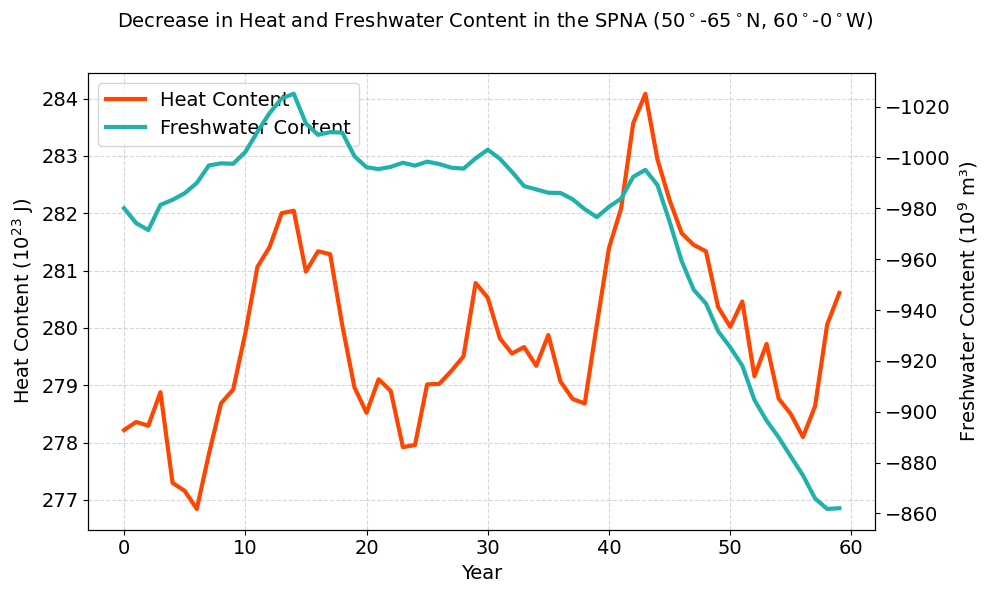

In [6]:
# Define a consistent font size
fontsize = 14

# Define the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot heat content time series
ax1.plot(heat_content.time, heat_content / 1e23, color='orangered', label='Heat Content', linewidth = 3)
ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel('Heat Content ($10^{23}$ J)', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Twin axis for freshwater content and flip y-axis
ax2 = ax1.twinx()
ax2.invert_yaxis()
ax2.plot(freshwater_content.time, freshwater_content / 1e9, color='lightseagreen', label='Freshwater Content', linewidth = 3)
ax2.set_ylabel('Freshwater Content ($10^9$ m³)', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=fontsize)

# Title
fig.suptitle(r'Decrease in Heat and Freshwater Content in the SPNA (50$^\circ$-65$^\circ$N, 60$^\circ$-0$^\circ$W)', fontsize=fontsize)

# Grid and Layout
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('Figure_ghg_decrease_content.png', bbox_inches='tight', dpi=300)

# Show the plot
#plt.show()

# SHF and HMXL

In [18]:
hmxl_aa_anomaly = ds_hmxl_aa.HMXL.isel(time=slice(41,59)).mean('time')-ds_hmxl_aa.HMXL.isel(time=slice(0,40)).mean('time')
hmxl_ghg_anomaly = ds_hmxl_ghg.HMXL.isel(time=slice(41,59)).mean('time')-ds_hmxl_aa.HMXL.isel(time=slice(0,40)).mean('time')
hmxl_anomaly_difference = hmxl_ghg_anomaly - hmxl_aa_anomaly

In [19]:
shf_aa_anomaly = ds_shf_aa.SHF.isel(time=slice(41,59)).mean('time')-ds_shf_aa.SHF.isel(time=slice(0,40)).mean('time')
shf_ghg_anomaly = ds_shf_ghg.SHF.isel(time=slice(41,59)).mean('time')-ds_shf_aa.SHF.isel(time=slice(0,40)).mean('time')
shf_anomaly_difference = shf_ghg_anomaly - shf_aa_anomaly

## Plotting comparison of time periods

In [31]:
# Function to prepare the data
def prepare_data(da):
    da = da.roll(nlon=+100)

    replacement_value = 0
    da['TLAT'] = xr.where(
        np.logical_or(np.isnan(da['TLAT']), np.logical_or(np.isinf(da['TLAT']), np.ma.getmask(da['TLAT']))),
        replacement_value,
        da['TLAT'])
    da['TLONG'] = xr.where(
        np.logical_or(np.isnan(da['TLONG']), np.logical_or(np.isinf(da['TLONG']), np.ma.getmask(da['TLONG']))),
        replacement_value,
        da['TLONG'])
    
    return da

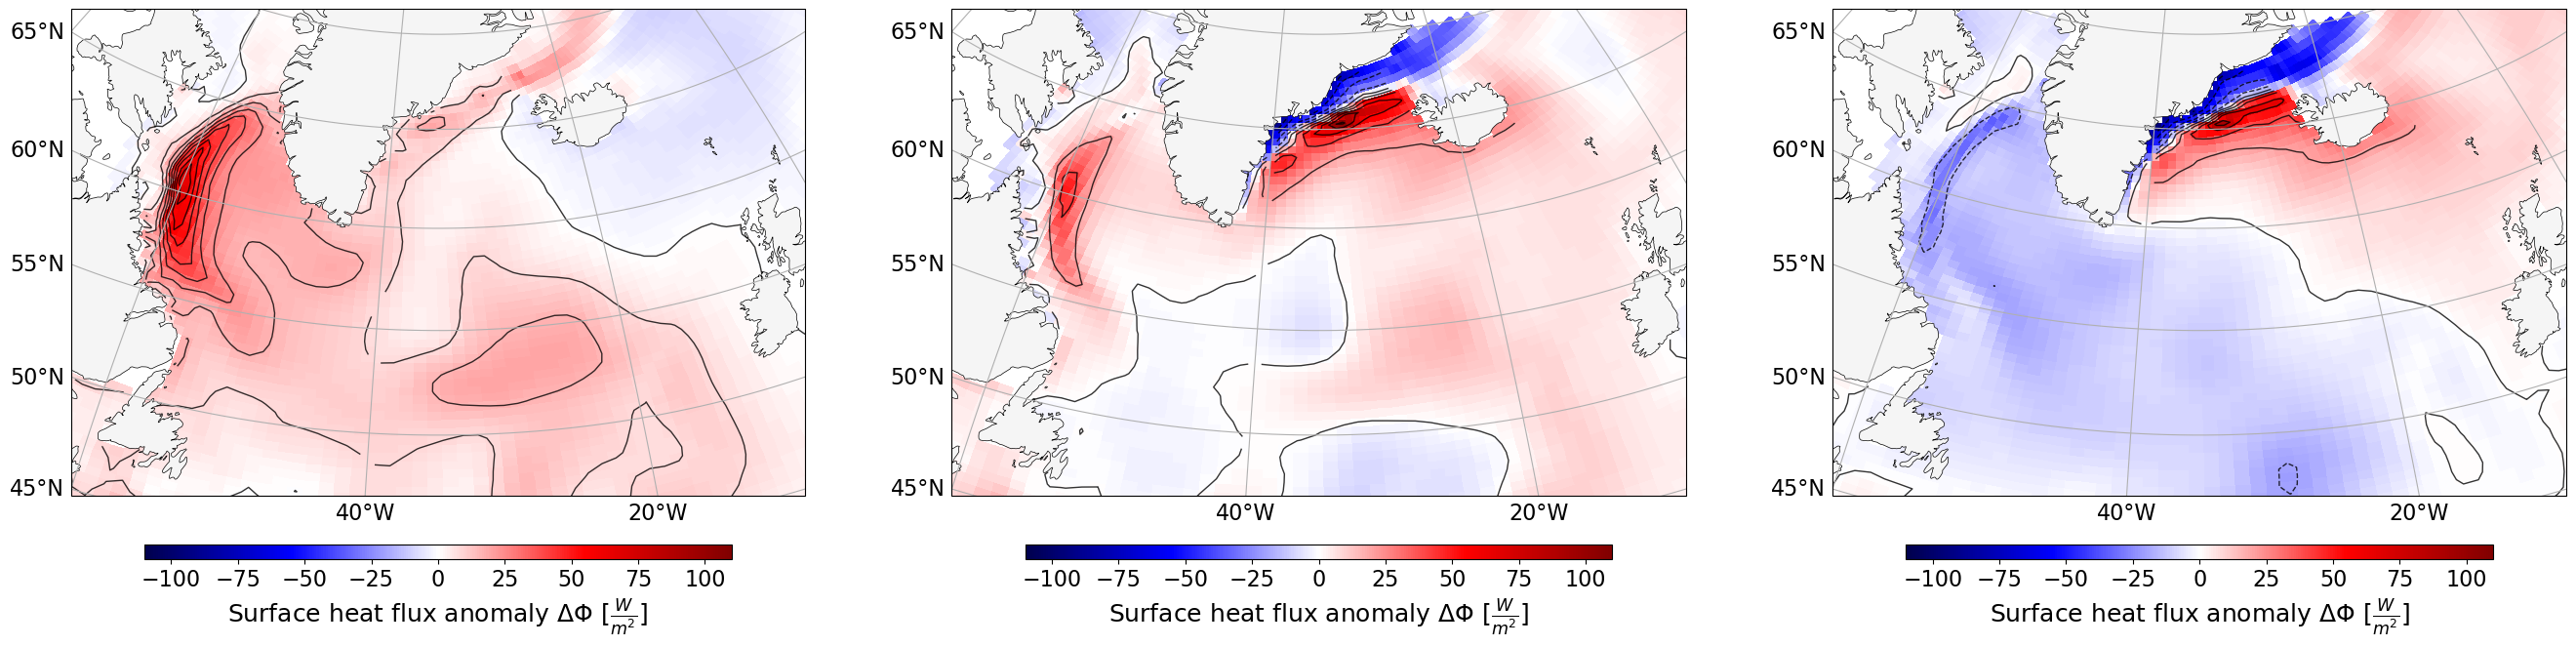

In [40]:
# Prepare plotting data for each dataset
plotting_data1 = prepare_data(shf_aa_anomaly)
plotting_data2 = prepare_data(shf_ghg_anomaly)
plotting_data3 = prepare_data(shf_anomaly_difference)

# Set up color and label sizes
cbar_kwargs = {
    'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
    'label': r'Surface heat flux anomaly $\Delta\Phi$ [$\frac{W}{m^2}$]', 'pad': 0.05
}
labelsize = 16

# Define plot limits
vmin = -110
vmax = 110

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(33, 13), subplot_kw={'projection': ccrs.Orthographic(central_latitude=40, central_longitude=-35)})

# Set extent for each subplot and plot data
for ax, plotting_data in zip(axes, [plotting_data1, plotting_data2, plotting_data3]):
    ax.set_extent([-60, -10, 45, 70], crs=ccrs.PlateCarree())

    # Add cartopy feature for coastlines
    nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

    # Plotting data as pcolormesh
    pc = plotting_data.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        x='TLONG',
        y='TLAT',
        cbar_kwargs=cbar_kwargs,
        cmap='seismic',
        vmin=vmin,
        vmax=vmax
    )

    # Adjust colorbar label size
    pc.colorbar.ax.tick_params(labelsize=labelsize)

    # Axis ticks
    ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': labelsize}
    gl.ylabel_style = {'size': labelsize}

    # Add coastlines
    ax.add_feature(nature_coast)
    #ax.set_title(f'Plot {plotting_data.name}', fontsize=labelsize)  # Adjust title as needed

    # Contour settings
    contour_levels = np.arange(np.floor(plotting_data.min().item()),
                               np.ceil(plotting_data.max().item()) + 0.5, 0.5)
    cs = ax.contour(plotting_data.TLONG, plotting_data.TLAT, 
                    plotting_data.where(mask > 0), 
                    levels=10, 
                    alpha=0.8,
                    linewidths=1, 
                    colors='black', 
                    transform=ccrs.PlateCarree())

# Adjust layout
plt.show()
#plt.savefig('Figure_shf_decrease_anomaly.png', bbox_inches='tight', dpi=300)

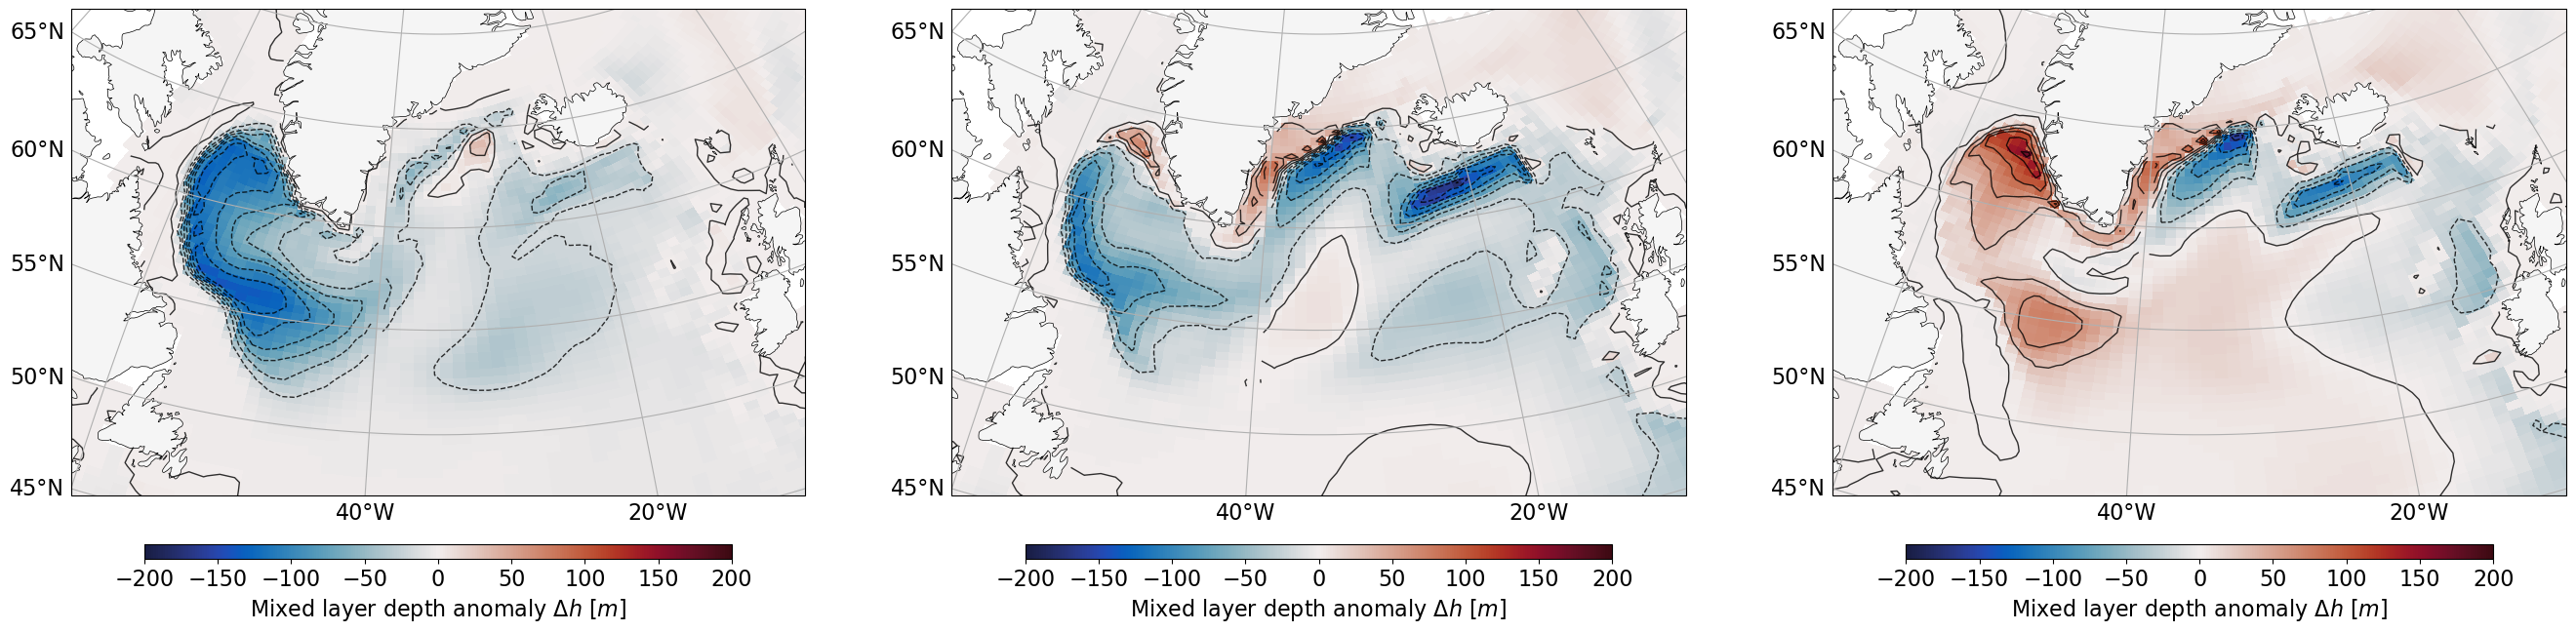

In [33]:
# Prepare plotting data for each dataset
plotting_data1 = prepare_data(hmxl_aa_anomaly)
plotting_data2 = prepare_data(hmxl_ghg_anomaly)
plotting_data3 = prepare_data(hmxl_anomaly_difference)

# Set up color and label sizes
cbar_kwargs = {
    'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
    'label': r'Mixed layer depth anomaly $\Delta h$ [$m$]', 'pad': 0.05
}
labelsize = 16

# Define plot limits
vmin = -200
vmax = 200

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(33, 13), subplot_kw={'projection': ccrs.Orthographic(central_latitude=40, central_longitude=-35)})

# Set extent for each subplot and plot data
for ax, plotting_data in zip(axes, [plotting_data1, plotting_data2, plotting_data3]):
    ax.set_extent([-60, -10, 45, 70], crs=ccrs.PlateCarree())

    # Add cartopy feature for coastlines
    nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

    # Plotting data as pcolormesh
    pc = plotting_data.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        x='TLONG',
        y='TLAT',
        cbar_kwargs=cbar_kwargs,
        cmap=cmo.balance,
        vmin=vmin,
        vmax=vmax
    )

    # Adjust colorbar label size
    pc.colorbar.ax.tick_params(labelsize=labelsize)
    pc.colorbar.set_label(r'Mixed layer depth anomaly $\Delta h$ [$m$]', size=labelsize)

    # Axis ticks
    ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': labelsize}
    gl.ylabel_style = {'size': labelsize}

    # Add coastlines
    ax.add_feature(nature_coast)
    #ax.set_title(f'Plot {plotting_data.name}', fontsize=labelsize)  # Adjust title as needed

    # Contour settings
    contour_levels = np.arange(np.floor(plotting_data.min().item()),
                               np.ceil(plotting_data.max().item()) + 0.5, 0.5)
    cs = ax.contour(plotting_data.TLONG, plotting_data.TLAT, 
                    plotting_data.where(mask > 0), 
                    levels=10, 
                    alpha=0.8,
                    linewidths=1, 
                    colors='black', 
                    transform=ccrs.PlateCarree())

# Adjust layout
plt.show()
#plt.savefig('Figure_hmxl_decrease_anomaly.png', bbox_inches='tight', dpi=300)

## Plotting single anomalies

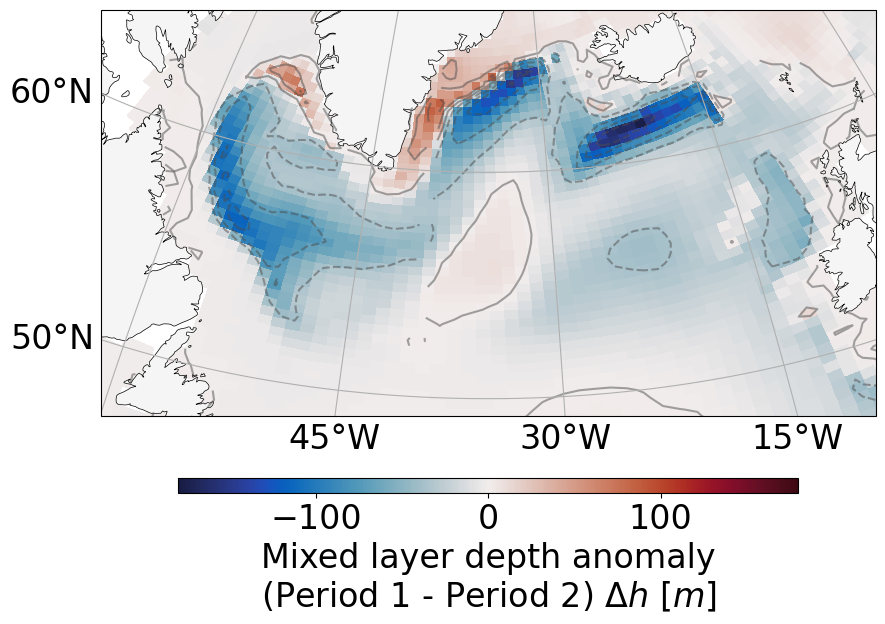

In [26]:
choice = 3
labelsize = 24 

if choice == 0:
    da = shf_aa_anomaly.roll(nlon=+100)
    save_name = 'Figure_anomaly_shf_aa.png'
    anom = 'shf'
elif choice == 1:
    da = shf_ghg_anomaly.roll(nlon=+100)
    save_name = 'Figure_anomaly_shf_ghg.png'
    anom = 'shf'
elif choice == 2:
    da = hmxl_aa_anomaly.roll(nlon=+100)
    save_name = 'Figure_anomaly_hmxl_aa.png'
    anom = 'hmxl'
elif choice == 3:
    da = hmxl_ghg_anomaly.roll(nlon=+100)
    save_name = 'Figure_anomaly_hmxl_ghg.png'
    anom = 'hmxl'

if anom == 'shf':
    cbar_kwargs = {
    'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
    'label': r'Surface heat flux anomaly'+'\n'+ r'(Period 1 - Period 2) $\Delta\Phi$ [$\frac{W}{m^2}$]', 'pad': 0.1}
    vmin = -110
    vmax = 110
    n_levels = 17
    cmap = 'seismic'
    
elif anom == 'hmxl':
    cbar_kwargs = {
    'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
    'label': r'Mixed layer depth anomaly'+'\n'+ r'(Period 1 - Period 2) $\Delta h$ [$m$]', 'pad': 0.1}
    vmin = -180
    vmax = 180
    n_levels = 11
    label =r'Mixed layer depth anomaly $\Delta h$ [$m$]'
    cmap = cmo.balance

replacement_value = 0
da['TLAT'] = xr.where(
    np.logical_or(np.isnan(da['TLAT']), np.logical_or(np.isinf(da['TLAT']), np.ma.getmask(da['TLAT']))),
    replacement_value,
    da['TLAT'])
da['TLONG'] = xr.where(
    np.logical_or(np.isnan(da['TLONG']), np.logical_or(np.isinf(da['TLONG']), np.ma.getmask(da['TLONG']))),
    replacement_value,
    da['TLONG'])


plotting_data = da


# Plot configuration
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-60, -10, 47, 66], crs=ccrs.PlateCarree())
pc = plotting_data.plot.pcolormesh( ax=ax, transform=ccrs.PlateCarree(), x='TLONG', y='TLAT',
    cbar_kwargs=cbar_kwargs, cmap=cmap, vmin=vmin, vmax=vmax)
pc.colorbar.ax.tick_params(labelsize=labelsize)
cbar = pc.colorbar
cbar.set_label(cbar_kwargs['label'], fontsize=labelsize)  # Set colorbar label font size
cbar.ax.tick_params(labelsize=labelsize)  # Set colorbar tick font size

#ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}
gl.xlocator = ticker.MultipleLocator(15) 
gl.ylocator = ticker.MultipleLocator(10)


ax.add_feature(nature_coast)
cs = ax.contour(plotting_data.TLONG, plotting_data.TLAT, 
                plotting_data.where(mask > 0), 
                levels = np.linspace(vmin, vmax, n_levels),
                linewidths=1.5, colors='#4d4d4d', alpha=0.5, transform=ccrs.PlateCarree())
#ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=labelsize)
    
plt.savefig(save_name, bbox_inches='tight', dpi=300, transparent=True)
#plt.show()